In [1]:
# import packages
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [244]:
%matplotlib notebook
%matplotlib notebook

# Function Definition

In [3]:
def loadgsdata(filename, variable = None):
    '''
    Load .mat file and turn it into grayscale
    filename: (STRING) file name of .mat file
    variable: (STRING) specific variable name to import in .mat file
    Return value
    data_gray: (NUMPY ARRAY) garyscale image/video data
    '''
    
    # load mat
    if variable == None:
        data = loadmat(filename)
    else:
        data = loadmat(filename)[variable]
    
    # grab dimensions of data
    idx = data.shape
    idx_gray = (idx[0], idx[1], idx[-1])
    data_gray = np.zeros(idx_gray, dtype = np.uint8)
    
    # turn data into grayscale
    for i in range(idx[-1]):
        data_gray[:,:,i] = cv2.cvtColor(data[:,:,:,i], cv2.COLOR_RGB2GRAY)
    
    return data_gray

In [58]:
def bg_darken(y, edge_l, edge_r, edge_u, edge_d):
    '''
    Eliminate a portion of background manually
    y: (NUMPY ARRAY) data of a set of images
    edge_l: (INT) pixel # of left edge
    edge_r: (INT) pixel # of right edge
    edge_u: (INT) pixel # of upper edge
    edge_d: (INT) pixel # of lower edge
    Return value
    yn: (NUMPY ARRAY) background-darkened data
    '''
    # grab dimensions of data
    idx = y.shape # idx[0]: height, idx[1]: width
    
    # in case the input is not integer
    edge_l = int(edge_l)
    edge_r = int(edge_r)
    edge_u = int(edge_u)
    edge_d = int(edge_d)
    
    # determine the effectiveness of edges
    if (edge_l >= edge_r) or (edge_u >= edge_d):
        print('Error: Incorrect edge values. The left (up) edge must have smaller value than the right (lower) edge. ')
        return y
    elif ( (0 <= edge_l <= idx[1]) or (0 <= edge_r <= idx[1]) \
          or (0 <= edge_u <= idx[0]) or (0 <= edge_d <= idx[0]) ) == False:
        print('Error: Incorrect edge values. Number should be in the region of image. ')
        return y
    
    # set region outside edge to zero intensity
    if len(idx) == 2: # image
        yn = y.copy()
        yn[:,:edge_l] = 0
        yn[:,edge_r:] = 0
        yn[:edge_u,:] = 0
        yn[edge_d:,:] = 0
        
    elif len(idx) == 3: # video
        
        yn = np.zeros(idx)
        # set elements to zero if below threshold
        for i in range(idx[-1]):
            yn[:,:,i] = y[:,:,i].copy()
            yn[:,:edge_l,i] = 0
            yn[:,edge_r:,i] = 0
            yn[:edge_u,:,i] = 0
            yn[edge_d:,:,i] = 0
        
    else:
        yn = y
        print('Error: Wrong dimensions. Input data must be a video or image in grayscale. ')
        
    return yn

In [1316]:
def traj_track(y, win_x, win_y, win2_start = 0, win2 = 0):
    '''
    Extract the trajectory of an object, i.e. find maximum intensity in the window
    y: (NUMPY ARRAY) data of a set of images w/ background treatment
    Return value
    trajx: (NUMPY ARRAY) (Dim: frames*1) the x-trajectory of the object
    trajy: (NUMPY ARRAY) (Dim: frames*1) the y-trajectory of the object
    win_x: (INT) window size of point tracking in x direction
    win_y: (INT) window size of point tracking in y direction
    win2: (INT) window size change of point tracking for 2nd window
    win2_start: (INT) frame # that 2nd window takes place
    '''
    # grab dimensions of data
    idx = y.shape # idx[0]: height, idx[1]: width
    
    # justify the effectiveness of windowsize
    if (win_x <= 0) or (win_x >= min(idx[0], idx[1])/2) or (win_y <= 0) or (win_y >= min(idx[0], idx[1])/2):
        print('Error: Wrong window size.')
        return 0, 0
    
    if ( (win_x - abs(win2)) <= 0) or ( (win_x + abs(win2)) >= min(idx[0], idx[1])/2) or\
    ( (win_y - abs(win2)) <= 0) or ( (win_y + abs(win2)) >= min(idx[0], idx[1])/2):
        print('Error: Wrong window size change.')
        return 0, 0
    
    if len(idx) == 2: # image
        
        max_idx = np.unravel_index(y.argmax(), idx)
        trajx = max_idx[1]
        trajy = max_idx[0]
        
    elif len(idx) == 3: # video
        
        trajx = np.zeros(idx[-1])
        trajy = np.zeros(idx[-1])
        
        # first image: traj = max intensity
        max_idx = np.unravel_index(y[:,:,0].argmax(), idx[:-1])
        trajx[0] = max_idx[1] # Note: the order is reversed for image
        trajy[0] = max_idx[0]
        
        # search only in the neighbor to avoid other illumination
        for i in range(1, idx[-1]): # i: frame number
            
            # window size
            window_x = win_x + (i >= win2_start) * win2
            window_y = win_y + (i >= win2_start) * win2
            
            # neighbor
            xmin = trajx[i-1] - window_x
            xmax = trajx[i-1] + window_x
            ymin = trajy[i-1] - window_y
            ymax = trajy[i-1] + window_y
            
            # justify the effectiveness of data range
            if xmin < 0:
                xmin = 0
                xmax = xmin + 2*window_x
            if xmax >= idx[1]:
                xmax = idx[1]
                xmin = xmax - 2*window_x
            if ymin < 0:
                ymin = 0
                ymax = ymin + 2*window_y
            if ymax >= idx[0]:
                ymax = idx[0]
                ymin = ymax - 2*window_y
            
            # find max intensity
            data_w = y[(int)(ymin):(int)(ymax), (int)(xmin):(int)(xmax), i].copy()
            max_idx = np.unravel_index(data_w.argmax(), data_w.shape)
            trajx[i] = trajx[i-1] - window_x + max_idx[1] # Note: the order is reversed for image
            trajy[i] = trajy[i-1] - window_y + max_idx[0]
        
    else:
        trajx = 0
        trajy = 0
        print('Error: Wrong dimensions. Input data must be a video or image in grayscale. ')
    
    return trajx, trajy

In [818]:
def traj_track_s(y):
    '''
    Extract the trajectory of an object, i.e. find maximum intensity in each image
    Simple version: w/o usage of window
    y: (NUMPY ARRAY) data of a set of images w/ background treatment
    Return value
    trajx: (NUMPY ARRAY) (Dim: frames*1) the x-trajectory of the object
    trajy: (NUMPY ARRAY) (Dim: frames*1) the y-trajectory of the object
    '''
    # grab dimensions of data
    idx = y.shape # idx[0]: height, idx[1]: width
    
    if len(idx) == 2: # image
        
        max_idx = np.unravel_index(y.argmax(), idx)
        trajx = max_idx[1]
        trajy = max_idx[0]
        
    elif len(idx) == 3: # video
        
        trajx = np.zeros(idx[-1])
        trajy = np.zeros(idx[-1])
        
        for i in range(idx[-1]): # i: frame number
            
            # find max intensity
            max_idx = np.unravel_index(y[:,:,i].argmax(), idx[:-1])
            trajx[i] = max_idx[1] # Note: the order is reversed for image
            trajy[i] = max_idx[0]
        
    else:
        trajx = 0
        trajy = 0
        print('Error: Wrong dimensions. Input data must be a video or image in grayscale. ')
    
    return trajx, trajy

In [1721]:
def traj_repair(y, window, interval, trajx0, trajy0, color):
    '''
    Repair the trajectory of an object with color identifier
    Work with traj_track_s(y)
    Input:
        y: (NUMPY ARRAY) data in RGB of a set of images w/ background treatment
        window: (List) [xmin, xmax, ymin, ymax]
        interval = [start, end]: (List) interval of those frames with tracking points hidden
        trajx0: (NUMPY ARRAY) the original x-trajectory of the object
        trajy0: (NUMPY ARRAY) the original y-trajectory of the object
        color: (List) [red, green, blue]
    Output:
        trajx: (NUMPY ARRAY) (Dim: frames*1) the x-trajectory of the object
        trajy: (NUMPY ARRAY) (Dim: frames*1) the y-trajectory of the object
    '''
    # grab dimensions of data
    idx = y.shape # idx[0]: height, idx[1]: width
    # convert to numpy array
    color = np.array(color)
    # window
    [xmin, xmax, ymin, ymax] = window
    
    # determine the effectiveness of bdrys
    if (xmin >= xmax) or (ymin >= ymax):
        print('Error: Invalid boundary values. ')
        return 0, 0
    elif ( (0 <= xmin <= idx[1]) or (0 <= xmax <= idx[1]) \
          or (0 <= ymin <= idx[0]) or (0 <= ymax <= idx[0]) ) == False:
        print('Error: Boundary values exceeding the range. ')
        return 0, 0
    
    if len(idx) == 4: # video
        
        trajx = trajx0.copy()
        trajy = trajy0.copy()
        
        for inc in interval:
            
            tstart = inc[0]
            tend = inc[1] + 1
            
            for i in range(tstart, tend):
                
                # find closest color in plot
                data = y[ymin:ymax, xmin:xmax, :, i].copy()
                dist = np.linalg.norm((data - color), axis = 2)
                min_idx = np.unravel_index(dist.argmin(), dist.shape)
                trajx[i] = xmin + min_idx[1] # Note: the order is reversed for image
                trajy[i] = ymin + min_idx[0]
        
    else:
        trajx = 0
        trajy = 0
        print('Error: Wrong dimensions. Input data must be a video in RGB. ')
    
    return trajx, trajy

In [1954]:
def spike_remover(mode0, threshold):
    '''
    Remove the spikes for better plot, and smoothen the curve
    Input:
        mode0: (NUMPY ARRAY) a vector of mode
        threshold: minimum value for relative spike intensity
    Outputput:
        mode: (NUMPY ARRAY) a vector of mode with spikes removed
    '''
    
    mode = mode0.copy()
    
    for i in range(1, len(mode)-2):
        
        if abs(mode[i] - mode[i-1]) >= threshold:
            # whether next one is also in the peak
            if abs(mode[i+1] - mode[i]) <= threshold:
                mode[i] = (2*mode[i-1] + mode[i+2])/3
                mode[i+1] = (mode[i-1] + 2*mode[i+2])/3
                
            else: 
                mode[i] = (mode[i-1] + mode[i+1])/2
    
    return mode

# Test 1

In [125]:
# load data from files
cam11 = loadgsdata('datasets/cam1_1.mat', variable = 'vidFrames1_1')
cam21 = loadgsdata('datasets/cam2_1.mat', variable = 'vidFrames2_1')
cam31 = loadgsdata('datasets/cam3_1.mat', variable = 'vidFrames3_1')

In [150]:
# starting & ending points for test
len11 = (cam11.shape)[-1]
len21 = (cam21.shape)[-1]
len31 = (cam31.shape)[-1]
shift11 = 1
shift21 = 10
shift31 = 0
len_t1 = min([len11-shift11, len21-shift21, len31-shift31])

# crop & synchronize data
cam11n = cam11[:,:,shift11:(len_t1 + shift11)].copy()
cam21n = cam21[:,:,shift21:(len_t1 + shift21)].copy()
cam31n = cam31[:,:,shift31:(len_t1 + shift31)].copy()

In [192]:
# plot grayscaled video segment for reference
plt.figure(2)
fnum = 41 # frame number
data_plot = cam11n[:,:,fnum]
plt.imshow(data_plot, cmap = plt.get_cmap("gray"))
# maximum intensity
maxidx = np.unravel_index(data_plot.argmax(), data_plot.shape)
plt.plot(maxidx[1], maxidx[0], 'go')
plt.show()

<IPython.core.display.Javascript object>

In [185]:
# background darkening
cam11nd = bg_darken(cam11n, 300, 400, 50, 390)
cam21nd = bg_darken(cam21n, 220, 380, 50, 320)
cam31nd = bg_darken(cam31n, 200, 425, 200, 400)

In [1317]:
# extract trajectory of paint can
trajx11, trajy11 = traj_track(cam11nd, 25, 25)
trajx21, trajy21 = traj_track(cam21nd, 25, 25)
trajx31, trajy31 = traj_track(cam31nd, 15, 15)

In [1318]:
# plot extracted trajectory (sanity check)
plt.figure(5, figsize = (10,4))
plt.subplot(1,3,1)
plt.plot(trajy11)
plt.subplot(1,3,2)
plt.plot(trajy21)
plt.subplot(1,3,3)
plt.plot(trajx31)
plt.show()

<IPython.core.display.Javascript object>

In [1151]:
# svd
a1 = np.stack((trajx11, trajy11, trajx21, trajy21, trajx31, trajy31))
for i in range(6): a1[i] = a1[i] - a1[i].mean()
u1, s1, v1 = np.linalg.svd(a1)

<IPython.core.display.Javascript object>


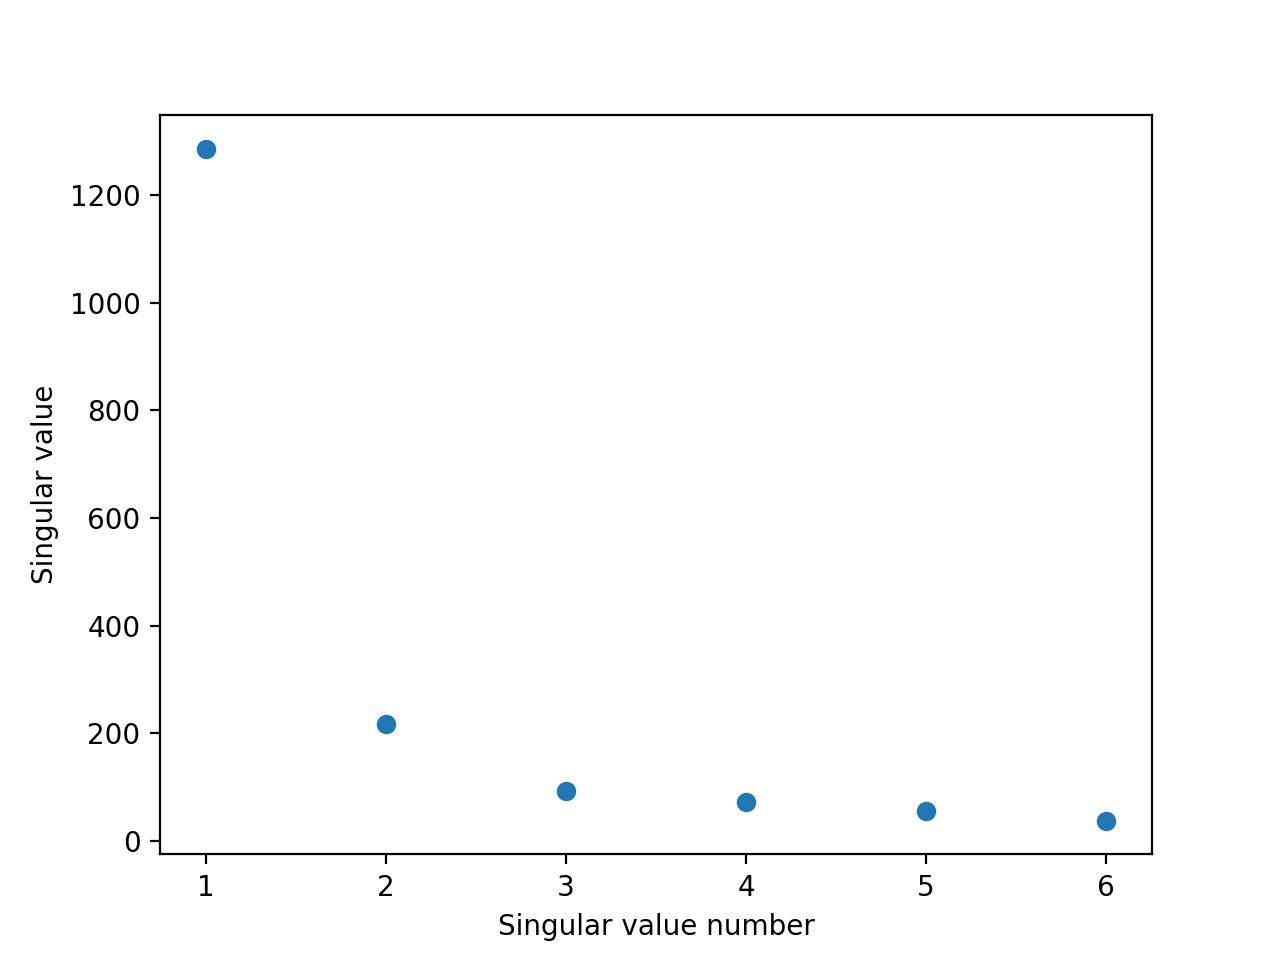

<IPython.core.display.Javascript object>

In [1978]:
# plot singular values & vectors
plt.figure(6)
plt.scatter(np.array([1,2,3,4,5,6]),s1) # sqrt of variance
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
plt.show()
plt.figure(7)
plt.plot(v1[0]*s1[0], label = '1st mode')
plt.plot(v1[1]*s1[1], label = '2nd mode')
plt.plot(v1[2]*s1[2], label = '3rd mode')
plt.plot(v1[3]*s1[3], label = '4th mode')
plt.plot(v1[4]*s1[4], label = '5th mode')
plt.plot(v1[5]*s1[5], label = '6th mode')
plt.legend(bbox_to_anchor=(0.9,0.7))
plt.xlabel('Frames')
plt.ylabel('Normalized Position')
plt.show()

# Test 2

In [302]:
# load data from files
cam12 = loadgsdata('datasets/cam1_2.mat', variable = 'vidFrames1_2')
cam22 = loadgsdata('datasets/cam2_2.mat', variable = 'vidFrames2_2')
cam32 = loadgsdata('datasets/cam3_2.mat', variable = 'vidFrames3_2')

In [303]:
# starting & ending points for test
len12 = (cam12.shape)[-1]
len22 = (cam22.shape)[-1]
len32 = (cam32.shape)[-1]
shift12 = 0
shift22 = 23
shift32 = 2
len_t2 = min([len12-shift12, len22-shift22, len32-shift32])

# crop & synchronize data
cam12n = cam12[:,:,shift12:(len_t2 + shift12)].copy()
cam22n = cam22[:,:,shift22:(len_t2 + shift22)].copy()
cam32n = cam32[:,:,shift32:(len_t2 + shift32)].copy()

<IPython.core.display.Javascript object>


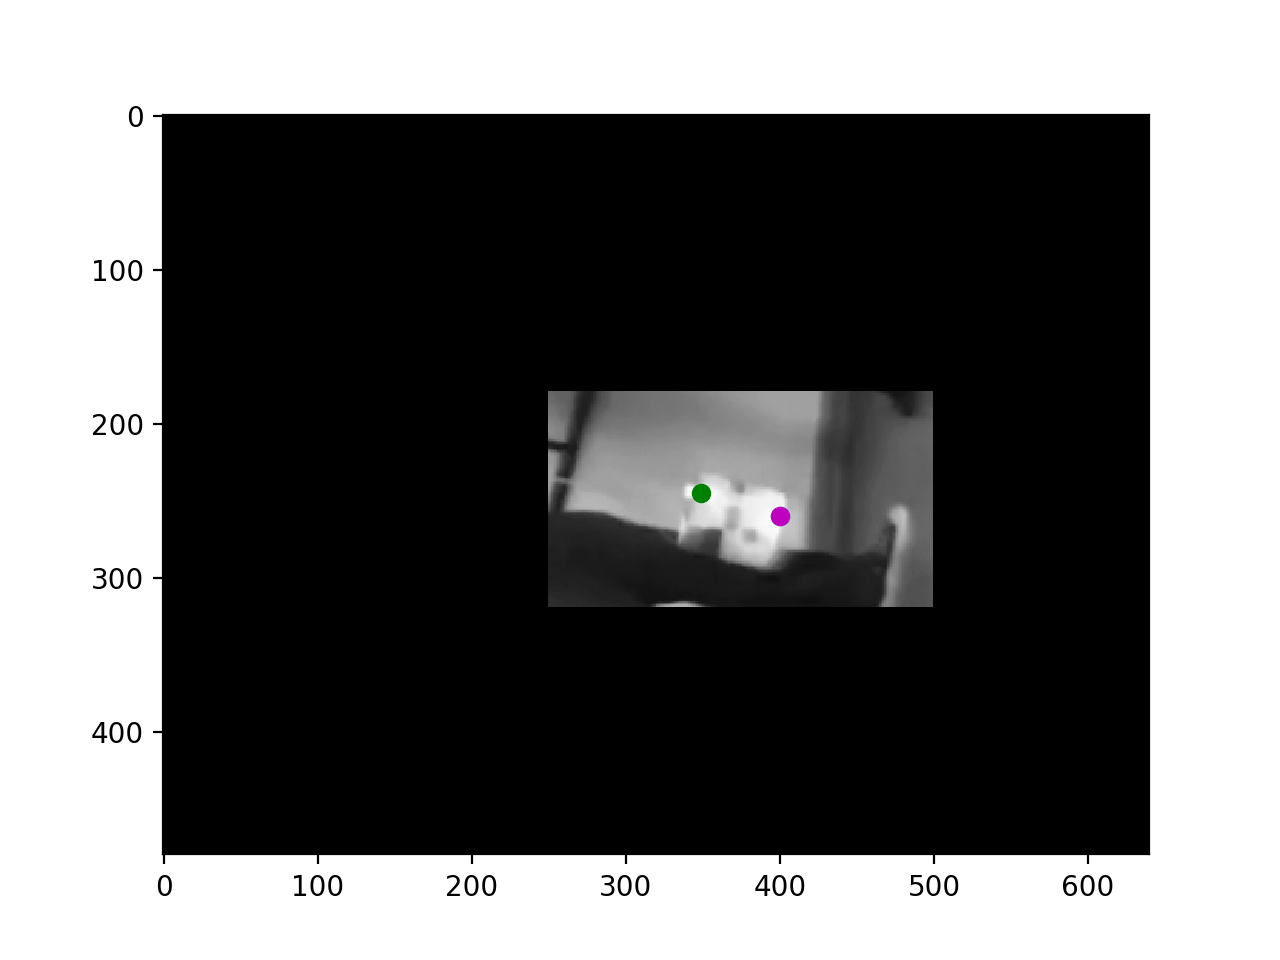

In [487]:
# plot grayscaled video segment for reference
plt.figure(11)
fnum = 266 # frame number
data_plot = cam32nd[:,:,fnum]
plt.imshow(data_plot, cmap = plt.get_cmap("gray"))
# maximum intensity
maxidx = np.unravel_index(data_plot.argmax(), data_plot.shape)
plt.plot(maxidx[1], maxidx[0], 'go')
plt.plot(trajx32[fnum], trajy32[fnum], 'co')
plt.show()

In [393]:
# background darkening
cam12nd = bg_darken(cam12n, 280, 450, 200, 430)
cam22nd = bg_darken(cam22n, 200, 420, 50, 430)
cam32nd = bg_darken(cam32n, 250, 500, 180, 320)

In [1319]:
# extract trajectory of paint can
trajx12, trajy12 = traj_track(cam12nd, 25, 25)
trajx22, trajy22 = traj_track(cam22nd, 35, 35)
trajx32, trajy32 = traj_track(cam32nd, 25, 25, win2_start = 260, win2 = 5)

<IPython.core.display.Javascript object>


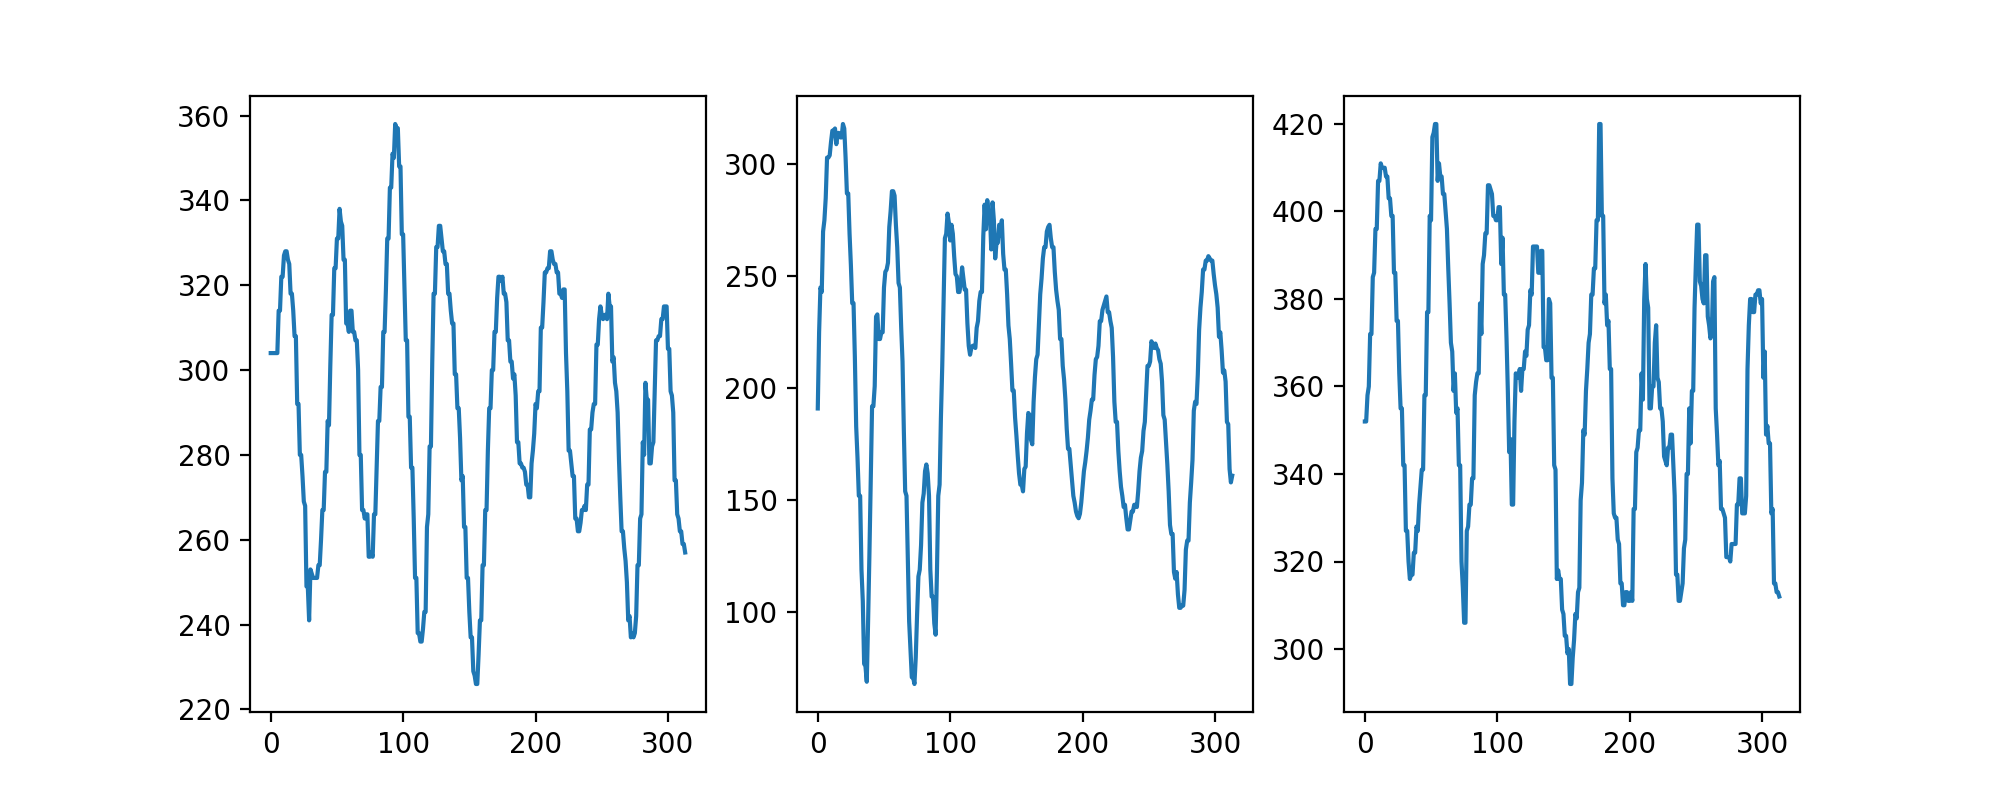

In [1320]:
# plot extracted trajectory (sanity check)
plt.figure(13, figsize = (10,4))
plt.subplot(1,3,1)
plt.plot(trajy12)
plt.subplot(1,3,2)
plt.plot(trajy22)
plt.subplot(1,3,3)
plt.plot(trajx32)
plt.show()

In [1143]:
# svd
a2 = np.stack((trajx12, trajy12, trajx22, trajy22, trajx32, trajy32))
for i in range(6): a2[i] = a2[i] - a2[i].mean()
u2, s2, v2 = np.linalg.svd(a2)

<IPython.core.display.Javascript object>


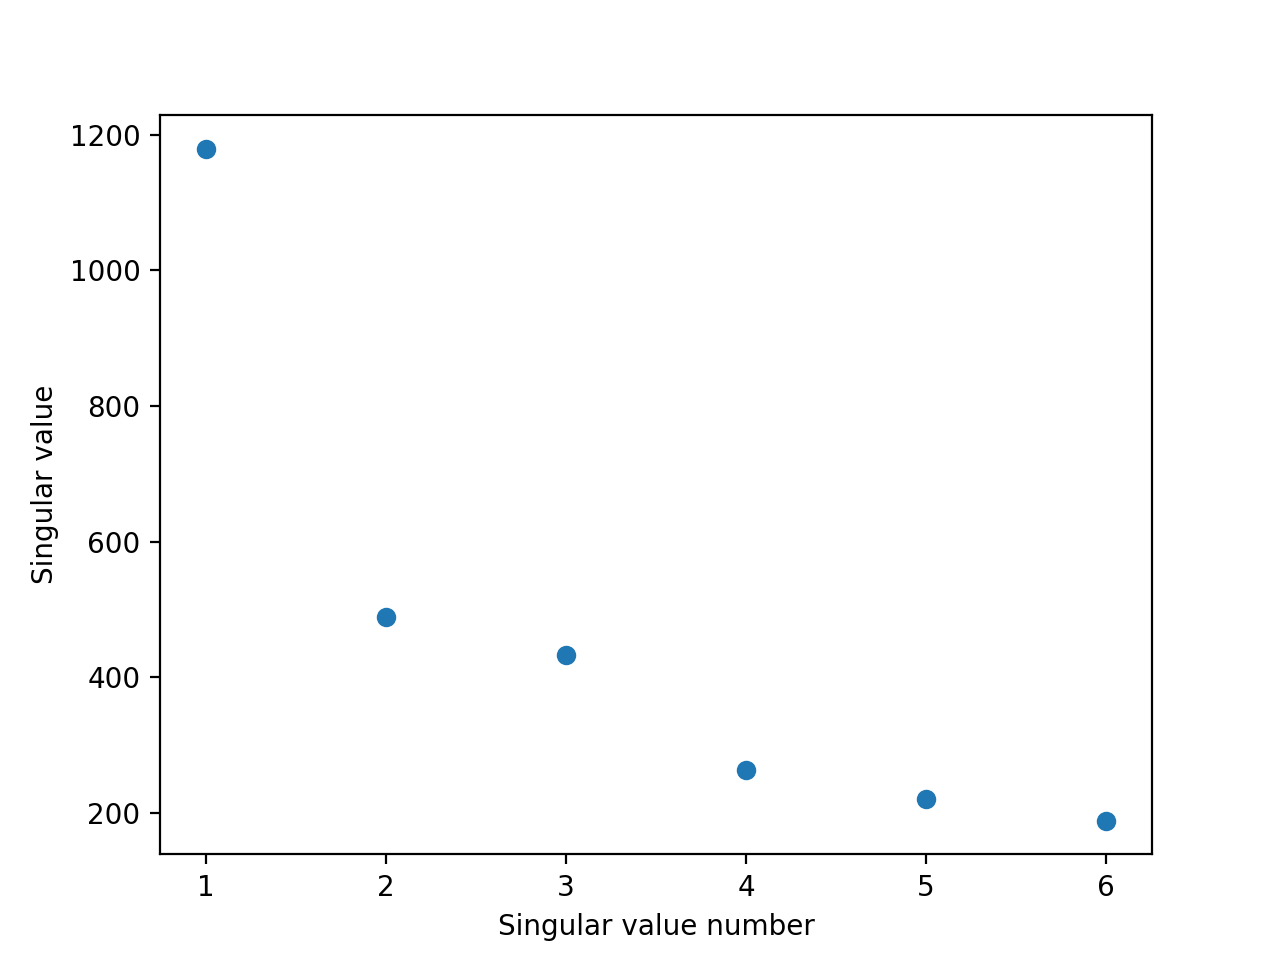

<IPython.core.display.Javascript object>


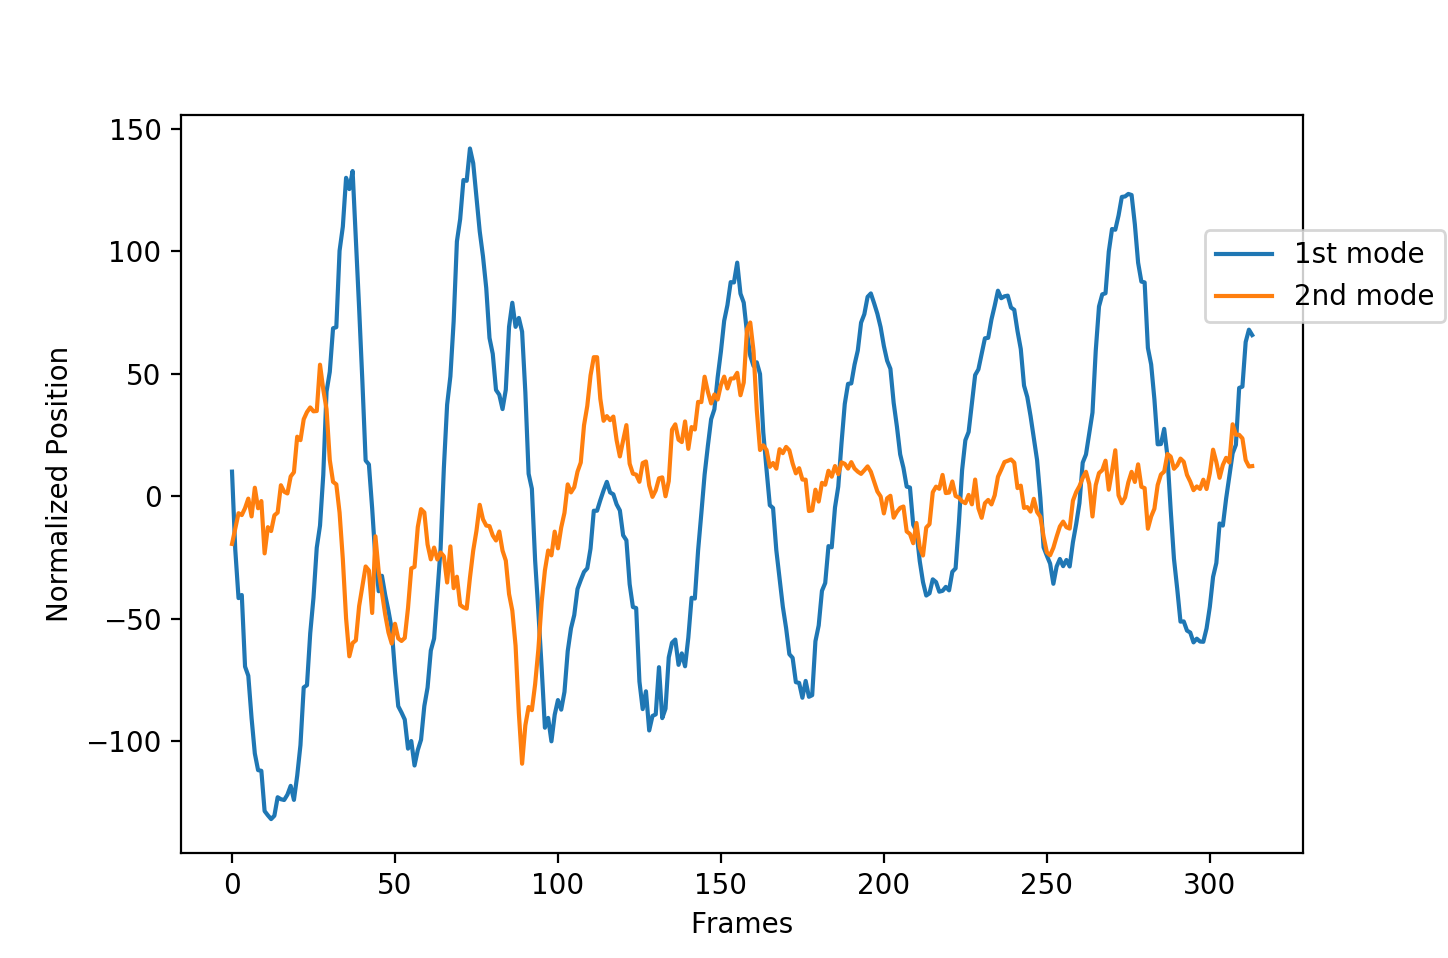

In [1980]:
# plot singular values & vectors
plt.figure(16)
plt.scatter(np.array([1,2,3,4,5,6]),s2) # sqrt of variance
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
plt.show()
plt.figure(17)
plt.plot(v2[0]*s2[0], label = '1st mode')
plt.plot(v2[1]*s2[1], label = '2nd mode')
#plt.plot(v2[2]*s2[2], label = '3rd mode')
#plt.plot(v2[3]*s2[3], label = '4th mode')
#plt.plot(v2[4]*s2[4], label = '5th mode')
#plt.plot(v2[5]*s2[5], label = '6th mode')
plt.legend(bbox_to_anchor=(0.9,0.7))
plt.xlabel('Frames')
plt.ylabel('Normalized Position')
plt.show()

# Test 3

In [516]:
# load data from files
cam13 = loadgsdata('datasets/cam1_3.mat', variable = 'vidFrames1_3')
cam23 = loadgsdata('datasets/cam2_3.mat', variable = 'vidFrames2_3')
cam33 = loadgsdata('datasets/cam3_3.mat', variable = 'vidFrames3_3')

In [521]:
# starting & ending points for test
len13 = (cam13.shape)[-1]
len23 = (cam23.shape)[-1]
len33 = (cam33.shape)[-1]
shift13 = 5
shift23 = 28
shift33 = 0
len_t3 = min([len13-shift13, len23-shift23, len33-shift33])

# crop & synchronize data
cam13n = cam13[:,:,shift13:(len_t3 + shift13)].copy()
cam23n = cam23[:,:,shift23:(len_t3 + shift23)].copy()
cam33n = cam33[:,:,shift33:(len_t3 + shift33)].copy()

<IPython.core.display.Javascript object>


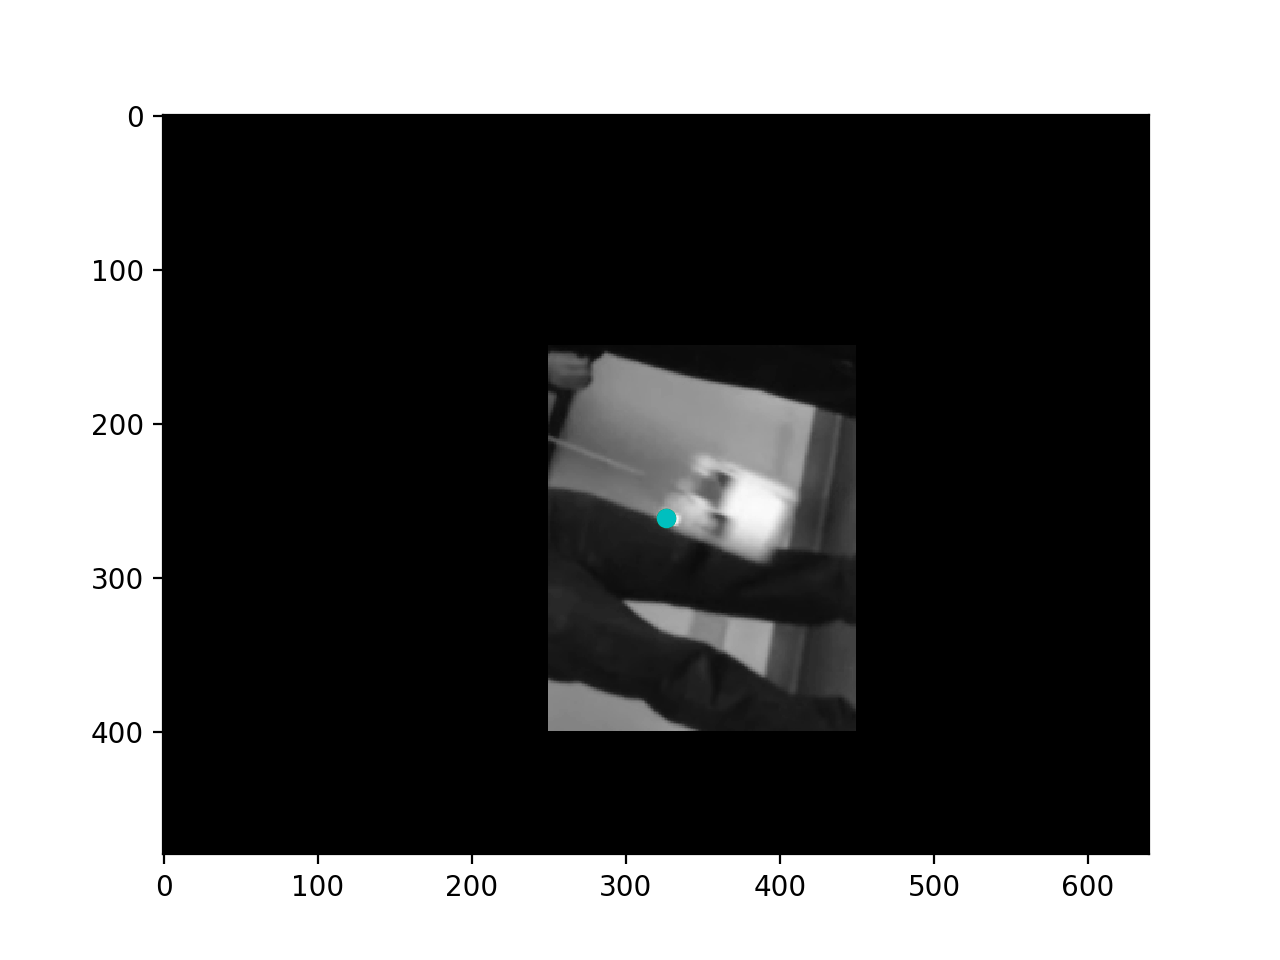

In [781]:
# plot grayscaled video segment for reference
plt.figure(21)
fnum = 200 # frame number
data_plot = cam33nd[:,:,fnum]
plt.imshow(data_plot, cmap = plt.get_cmap("gray"))

# maximum intensity
maxidx = np.unravel_index(data_plot.argmax(), data_plot.shape)
plt.plot(maxidx[1], maxidx[0], 'go')
# plot calculated trajectory
plt.plot(trajx33[fnum], trajy33[fnum], 'co')
plt.show()

In [762]:
# background darkening
cam13nd = bg_darken(cam13n, 200, 400, 150, 400)
cam23nd = bg_darken(cam23n, 200, 450, 200, 400)
cam33nd = bg_darken(cam33n, 250, 450, 150, 400)

In [1321]:
# extract trajectory of paint can (have to use a lower point for cam 1 & 2)
trajx13, trajy13 = traj_track(np.flip(cam13nd, 2), 25, 25, win2_start = 169, win2 = -5) # flip for better result
trajx13 = np.flip(trajx13)
trajy13 = np.flip(trajy13)
trajx23, trajy23 = traj_track(cam23nd, 15, 15)
trajx33, trajy33 = traj_track(cam33nd, 25, 25)

<IPython.core.display.Javascript object>


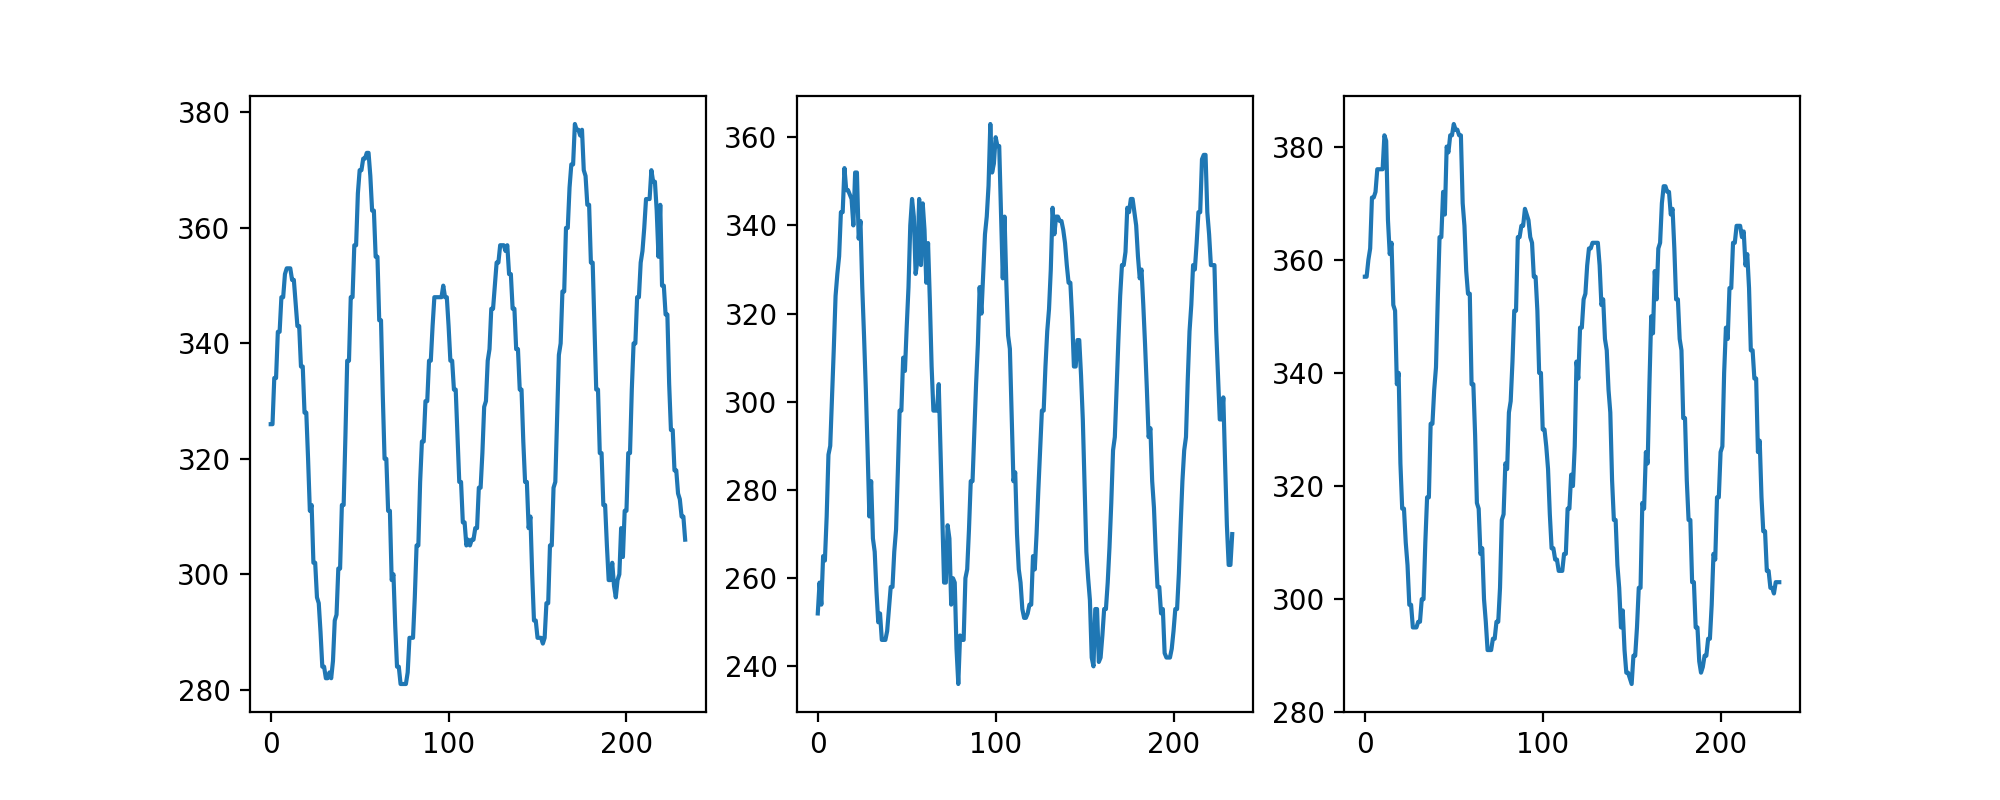

In [1322]:
# plot extracted trajectory (sanity check)
plt.figure(23, figsize = (10,4))
plt.subplot(1,3,1)
plt.plot(trajy13)
plt.subplot(1,3,2)
plt.plot(trajy23)
plt.subplot(1,3,3)
plt.plot(trajx33)
plt.show()

In [1161]:
# svd
a3 = np.stack((trajx13, trajy13, trajx23, trajy23, trajx33, trajy33))
for i in range(6): a3[i] = a3[i] - a3[i].mean()
u3, s3, v3 = np.linalg.svd(a3)

<IPython.core.display.Javascript object>


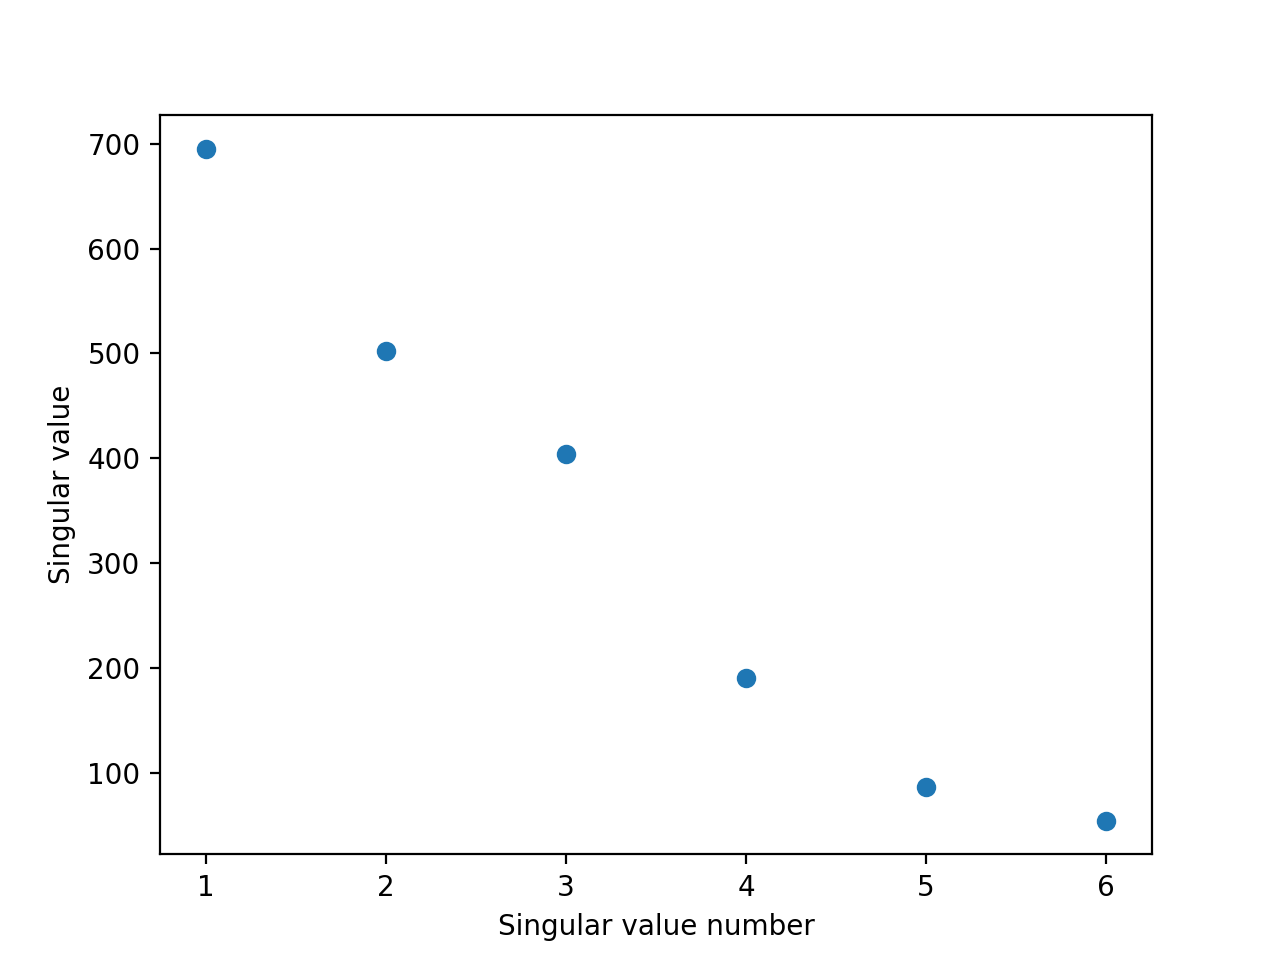

<IPython.core.display.Javascript object>


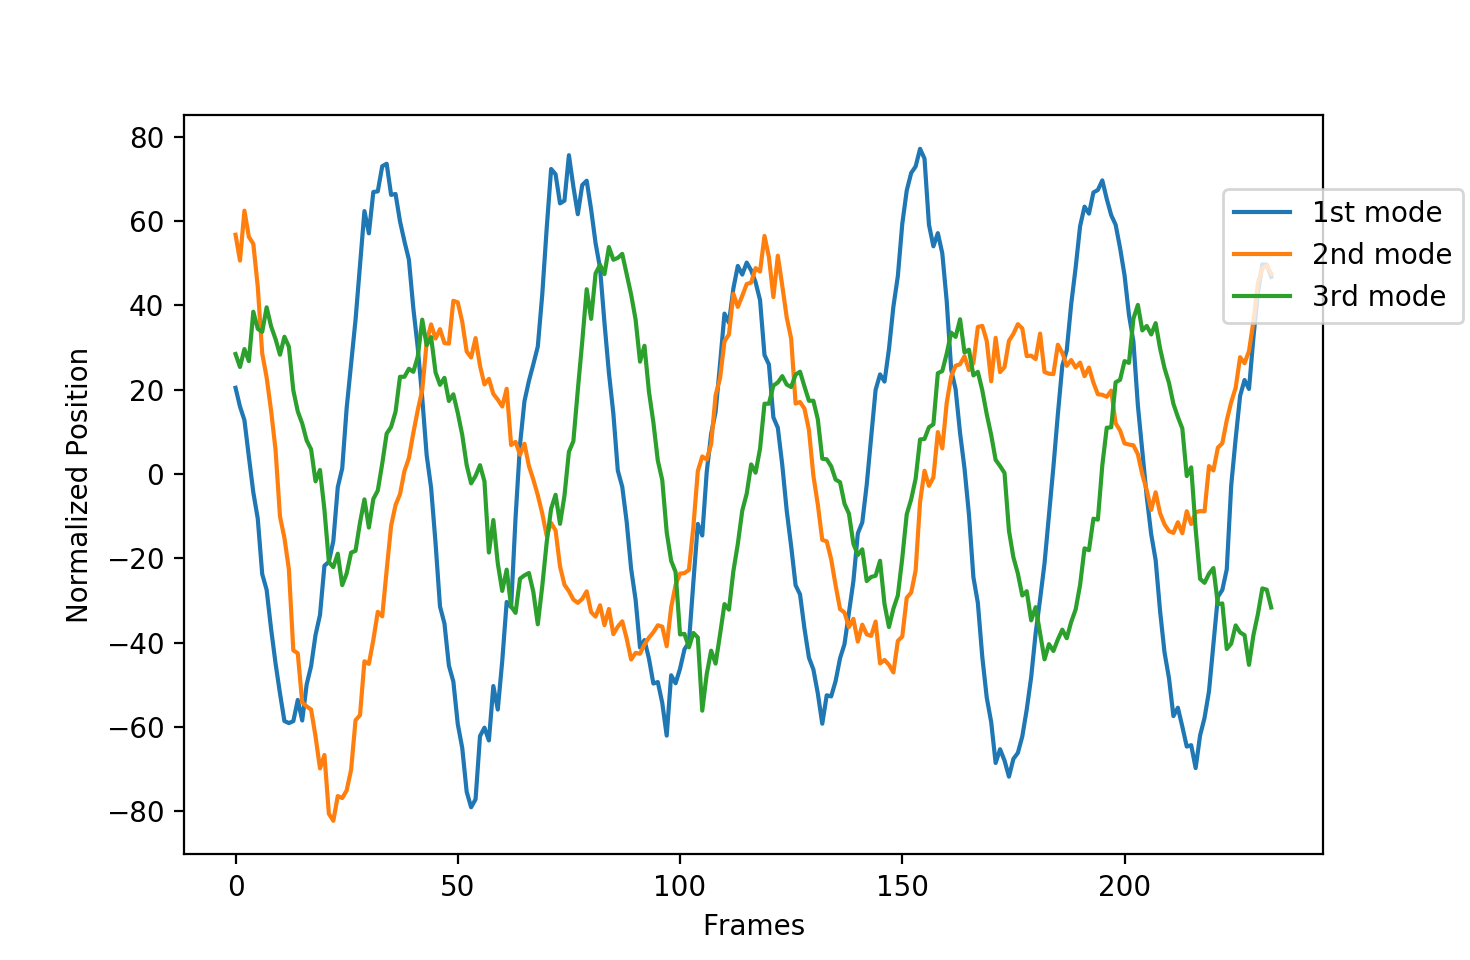

In [1983]:
# plot singular values & vectors
plt.figure(26)
plt.scatter(np.array([1,2,3,4,5,6]),s3)
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
plt.show()
plt.figure(27)
plt.plot(v3[0]*s3[0], label = '1st mode')
plt.plot(v3[1]*s3[1], label = '2nd mode')
plt.plot(v3[2]*s3[2], label = '3rd mode')
#plt.plot(v3[3]*s3[3], label = '4th mode')
#plt.plot(v3[4]*s3[4], label = '5th mode')
#plt.plot(v3[5]*s3[5], label = '6th mode')
plt.legend(bbox_to_anchor=(0.9,0.7))
plt.xlabel('Frames')
plt.ylabel('Normalized Position')
plt.show()

# Test 4

## Import & synchronize data

In [1208]:
# load color data from files
cam14c = loadmat('datasets/cam1_4.mat')['vidFrames1_4']
cam24c = loadmat('datasets/cam2_4.mat')['vidFrames2_4']
cam34c = loadmat('datasets/cam3_4.mat')['vidFrames3_4']

In [790]:
# load grayscale data from files
cam14 = loadgsdata('datasets/cam1_4.mat', variable = 'vidFrames1_4')
cam24 = loadgsdata('datasets/cam2_4.mat', variable = 'vidFrames2_4')
cam34 = loadgsdata('datasets/cam3_4.mat', variable = 'vidFrames3_4')

In [791]:
# starting & ending points for test
len14 = (cam14.shape)[-1]
len24 = (cam24.shape)[-1]
len34 = (cam34.shape)[-1]
shift14 = 2
shift24 = 7
shift34 = 0
len_t4 = min([len14-shift14, len24-shift24, len34-shift34])

# crop & synchronize data
cam14n = cam14[:,:,shift14:(len_t4 + shift14)].copy()
cam24n = cam24[:,:,shift24:(len_t4 + shift24)].copy()
cam34n = cam34[:,:,shift34:(len_t4 + shift34)].copy()

In [1209]:
# crop & synchronize color data
cam14cn = cam14c[:,:,:,shift14:(len_t4 + shift14)].copy()
cam24cn = cam24c[:,:,:,shift24:(len_t4 + shift24)].copy()
cam34cn = cam34c[:,:,:,shift34:(len_t4 + shift34)].copy()

<IPython.core.display.Javascript object>


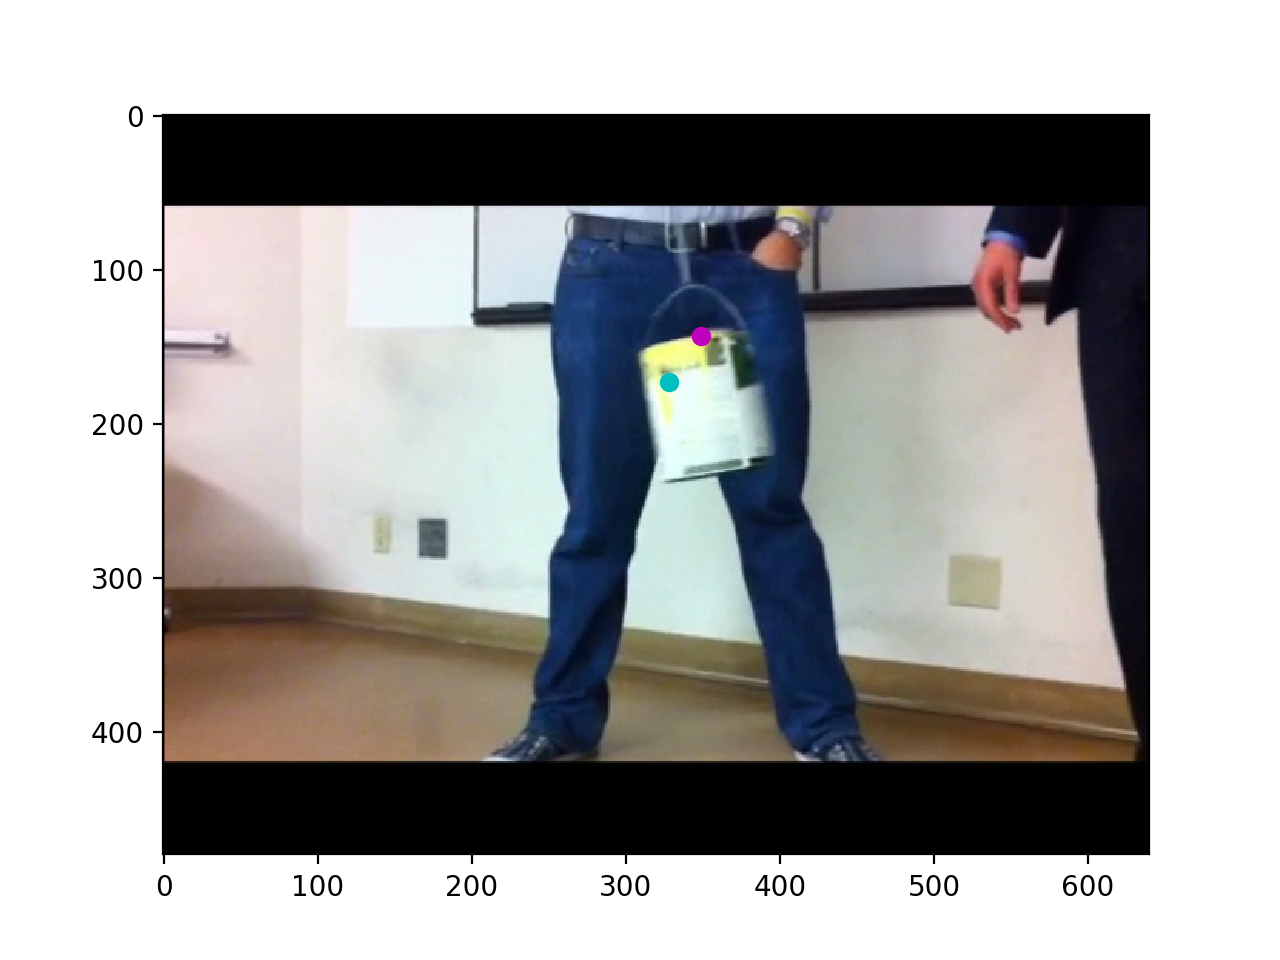

In [1890]:
# plot with R, G, B channel
plt.figure(51)
fnum = 10 # frame number

data_plot = cam24cn[:,:,:,fnum]
plt.imshow(data_plot)

# plot calculated trajectory
plt.plot(trajx24[fnum], trajy24[fnum], 'co')
plt.plot(trajx24rrr[fnum], trajy24rrr[fnum], 'mo')
plt.show()

## Extract trajectory with traj_track_s(y)

In [796]:
# background darkening
cam14nd = bg_darken(cam14n, 300, 460, 200, 430)
cam24nd = bg_darken(cam24n, 200, 430, 50, 400)
cam34nd = bg_darken(cam34n, 250, 500, 120, 300)

In [1255]:
# extract trajectory of paint can (have to use a lower point for cam 1 & 2)
trajx14, trajy14 = traj_track_s(cam14nd)
trajx24, trajy24 = traj_track_s(cam24nd)
trajx34, trajy34 = traj_track_s(cam34nd)

<IPython.core.display.Javascript object>


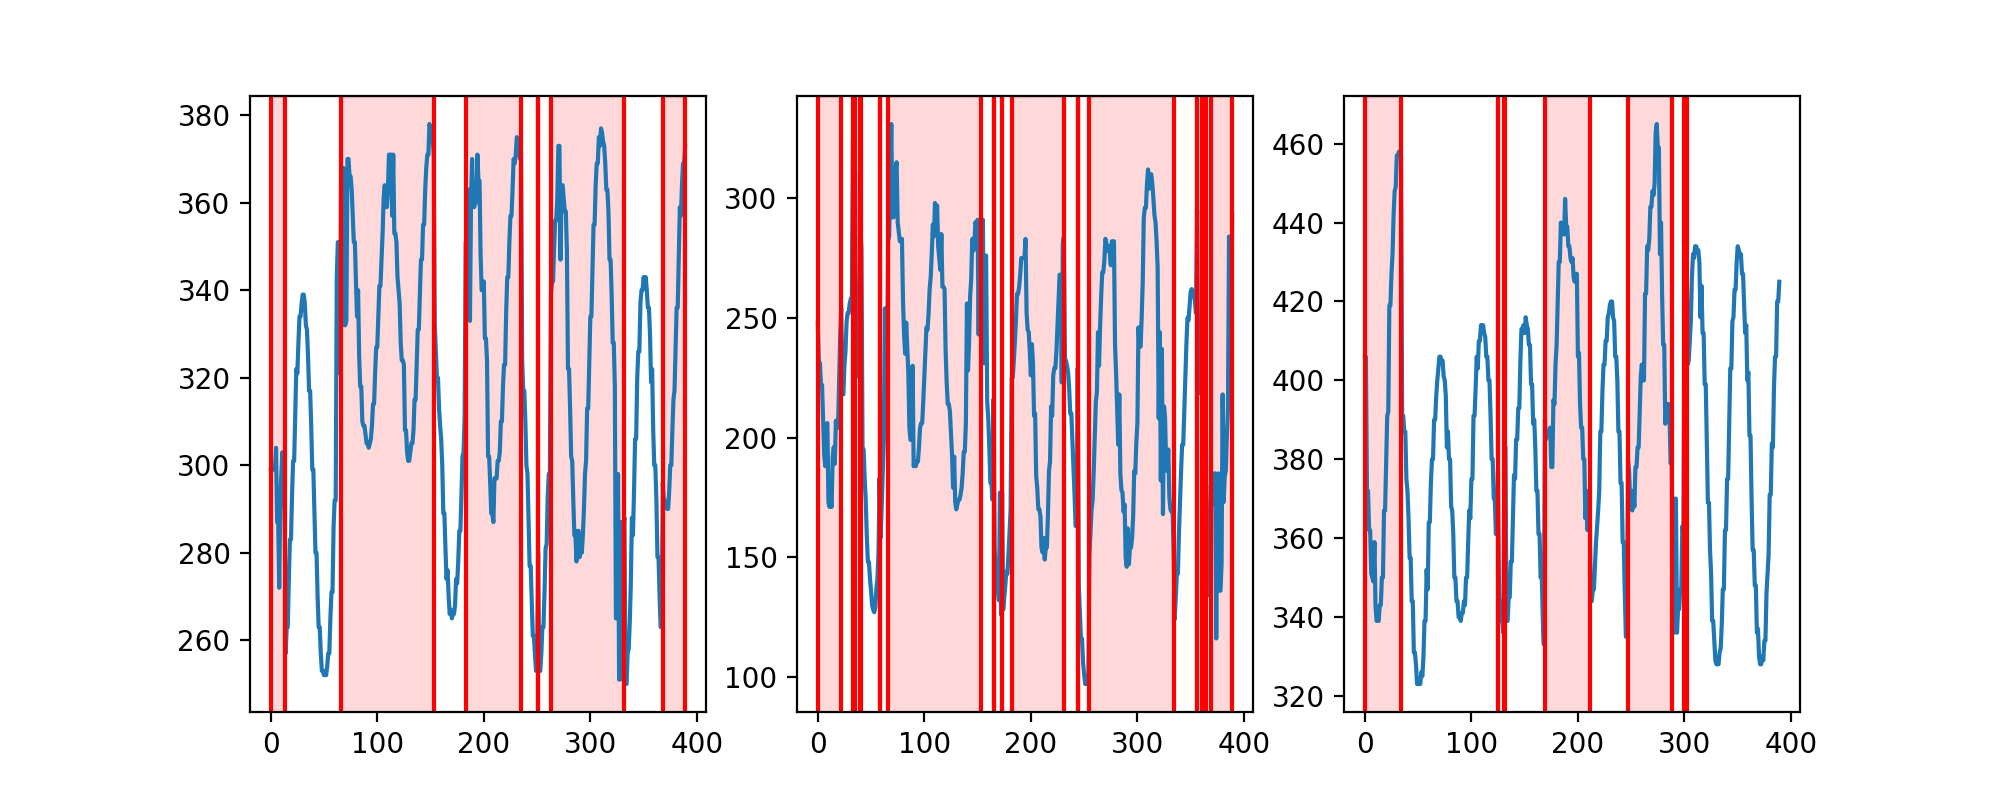

In [1081]:
# plot extracted trajectory (problematic region are shaded)
plt.figure(33, figsize = (10,4))

plt.subplot(1,3,1)
plt.plot(trajy14)
vspan1 = np.array([[0, 13], [66, 153], [183, 235], [251, 251], [263, 332], [368, 389]])
vlines1 = np.ndarray.flatten(vspan1)
for x in vlines1:
    plt.axvline(x, color='r')
for x in vspan1:
    plt.axvspan(x[0], x[1], alpha=0.15, color='red')
    
plt.subplot(1,3,2)
plt.plot(trajy24)
vspan2 = np.array([[0, 22], [33, 35], [40, 41], [58, 58], [66, 153], [165, 165], [173, 173],\
                   [182, 231], [244, 244], [255, 334], [356, 356], [361, 364], [369, 389]])
vlines2 = np.ndarray.flatten(vspan2)
for x in vlines2:
    plt.axvline(x, color='r')
for x in vspan2:
    plt.axvspan(x[0], x[1], alpha=0.15, color='red')

plt.subplot(1,3,3)
plt.plot(trajx34)
vspan3 = np.array([[0, 34], [125, 125], [131, 132], [169, 211], [247, 288], [300, 302]])
vlines3 = np.ndarray.flatten(vspan3)
for x in vlines3:
    plt.axvline(x, color='r')
for x in vspan3:
    plt.axvspan(x[0], x[1], alpha=0.15, color='red')

plt.show()

## Repair the trajectory in the regions with flashlight hidden

In [1827]:
#flashlight1 = [217, 153, 160] # lighter
flashlight1 = [209, 146, 152] # darker
trajx14rrr, trajy14rrr = traj_repair(cam14cn, [300, 460, 200, 430], vspan1, trajx14, trajy14, flashlight1)

In [1888]:
flashlight2 = [220, 176, 188] # darker
trajx24rrr, trajy24rrr = traj_repair(cam24cn, [200, 430, 90, 400], vspan2, trajx24, trajy24, flashlight2)

In [1723]:
flashlight3 = [193, 155, 147]
trajx34rrr, trajy34rrr = traj_repair(cam34cn, [250, 500, 120, 300], vspan3, trajx34, trajy34, flashlight3)

## Compare the repaired trajectory to the original

In [1830]:
# original vs repair (cam1)
plt.figure(35, figsize = (9,4))
plt.subplot(1,2,1)
plt.plot(trajy14, label = 'original')
plt.plot(trajy14rrr, label = 'repair')
vspan1 = np.array([[0, 13], [66, 153], [183, 235], [251, 251], [263, 332], [368, 389]])
vlines1 = np.ndarray.flatten(vspan1)
for x in vlines1:
    plt.axvline(x, color='r')
for x in vspan1:
    plt.axvspan(x[0], x[1], alpha=0.15, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.plot(trajx14, label = 'original')
plt.plot(trajx14rrr, label = 'repair')
for x in vlines1:
    plt.axvline(x, color='r')
for x in vspan1:
    plt.axvspan(x[0], x[1], alpha=0.15, color='red')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


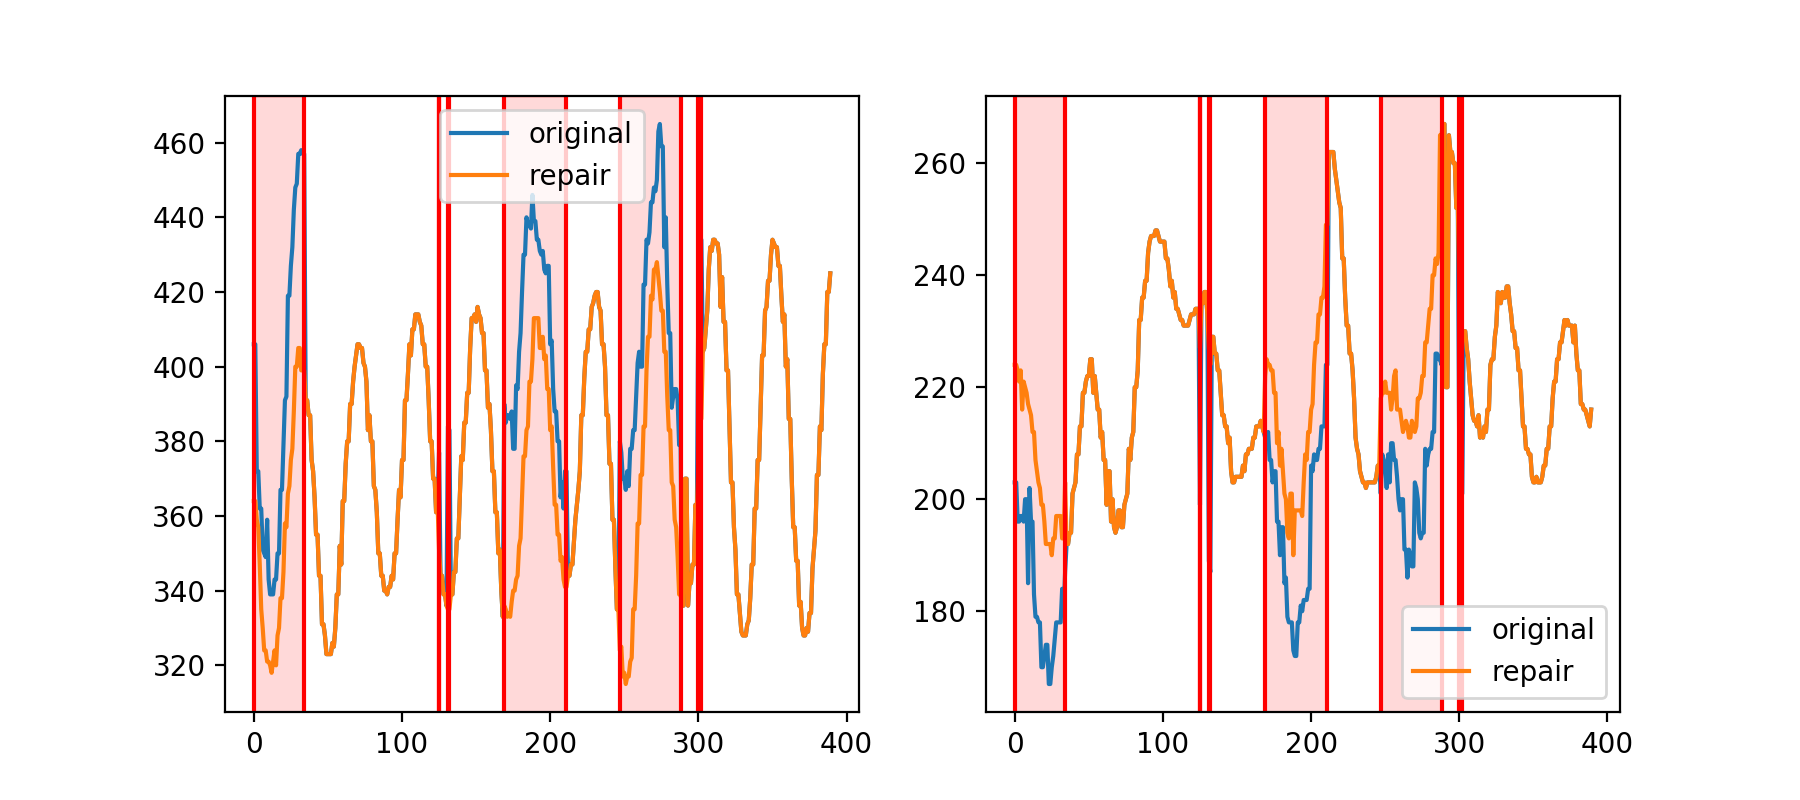

In [1829]:
# original vs repair (cam3)
plt.figure(36, figsize = (9,4))
plt.subplot(1,2,1)
plt.plot(trajx34, label = 'original')
plt.plot(trajx34rrr, label = 'repair')
vspan3 = np.array([[0, 34], [125, 125], [131, 132], [169, 211], [247, 288], [300, 302]])
vlines3 = np.ndarray.flatten(vspan3)
for x in vlines3:
    plt.axvline(x, color='r')
for x in vspan3:
    plt.axvspan(x[0], x[1], alpha=0.15, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.plot(trajy34, label = 'original')
plt.plot(trajy34rrr, label = 'repair')
for x in vlines3:
    plt.axvline(x, color='r')
for x in vspan3:
    plt.axvspan(x[0], x[1], alpha=0.15, color='red')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


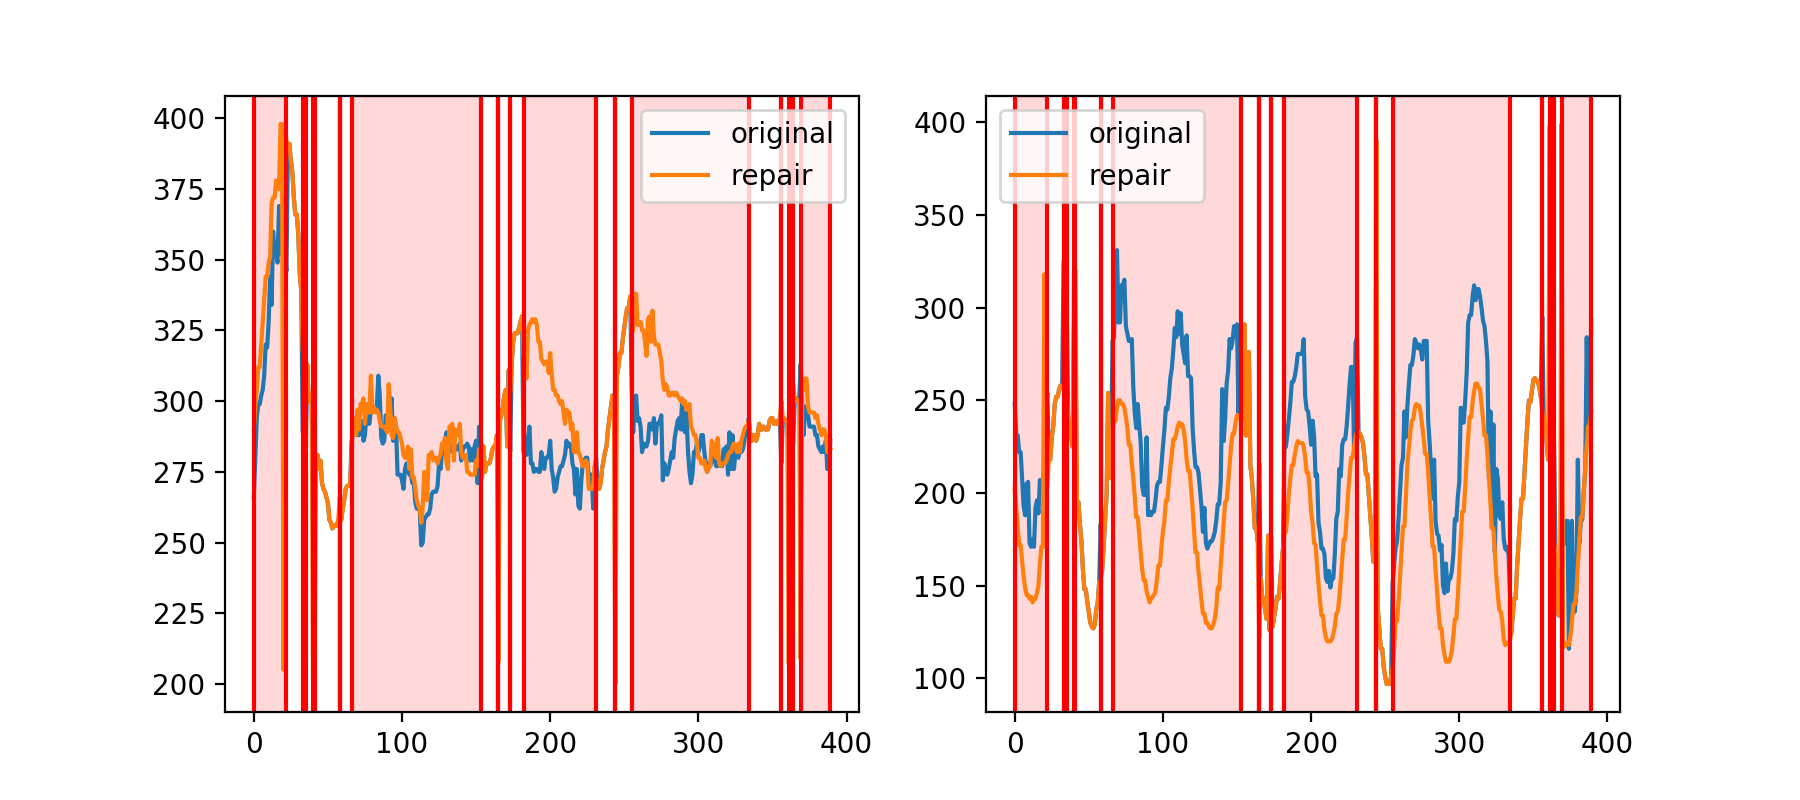

In [1889]:
# original vs repair (cam2)
plt.figure(37, figsize = (9,4))
plt.subplot(1,2,1)
plt.plot(trajx24, label = 'original')
plt.plot(trajx24rrr, label = 'repair')
vspan2 = np.array([[0, 22], [33, 35], [40, 41], [58, 58], [66, 153], [165, 165], [173, 173],\
                   [182, 231], [244, 244], [255, 334], [356, 356], [361, 364], [369, 389]])
vlines2 = np.ndarray.flatten(vspan2)
for x in vlines2:
    plt.axvline(x, color='r')
for x in vspan2:
    plt.axvspan(x[0], x[1], alpha=0.15, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.plot(trajy24, label = 'original')
plt.plot(trajy24rrr, label = 'repair')
for x in vlines2:
    plt.axvline(x, color='r')
for x in vspan2:
    plt.axvspan(x[0], x[1], alpha=0.15, color='red')
plt.legend()

plt.show()

# SVD

In [1891]:
# svd
a4 = np.stack((trajx14rrr, trajy14rrr, trajx24rrr, trajy24rrr, trajx34rrr, trajy34rrr))
for i in range(6): a4[i] = a4[i] - a4[i].mean()
u4, s4, v4 = np.linalg.svd(a4)

<IPython.core.display.Javascript object>


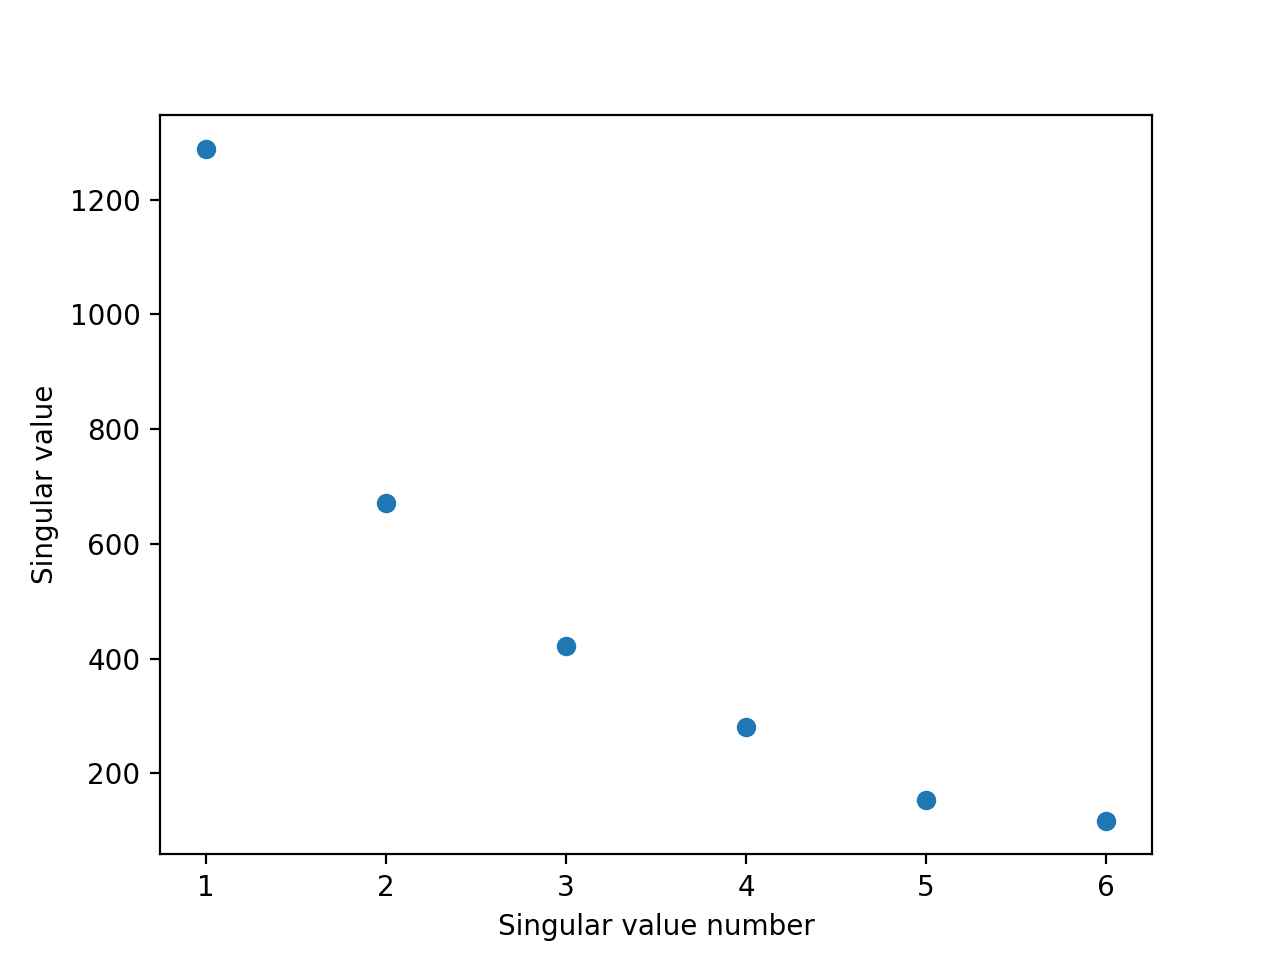

<IPython.core.display.Javascript object>


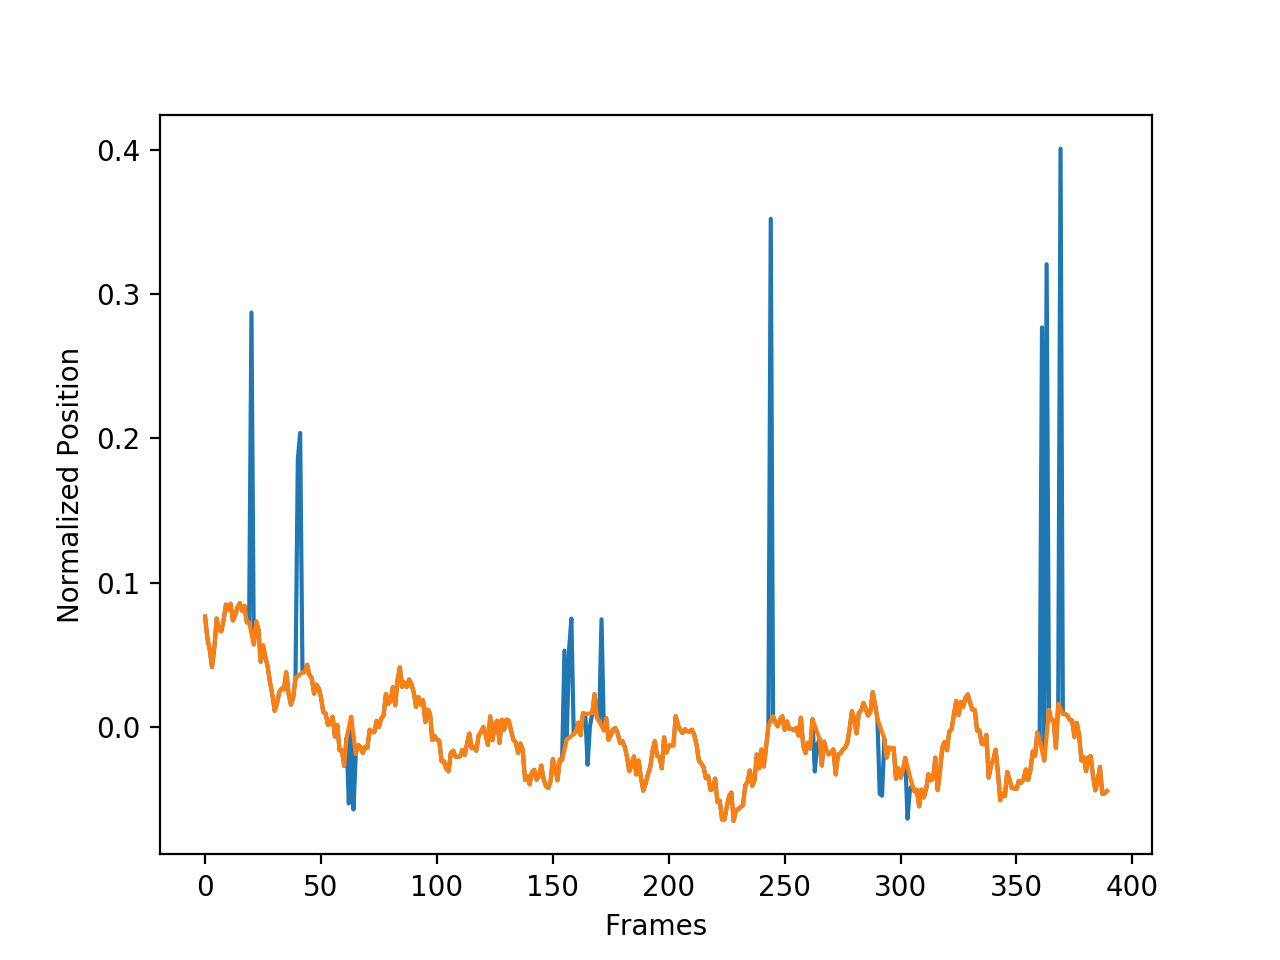

In [1989]:
# plot singular values & vectors
plt.figure(66)
plt.scatter(np.array([1,2,3,4,5,6]), s4)
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
plt.show()
plt.figure(67)
plt.plot(v4[2])
plt.plot(v4n[2])
plt.xlabel('Frames')
plt.ylabel('Normalized Position')
plt.show()

# Remove spikes due to incontinuity in repairing the trajectory

In [1988]:
# remove spikes
v4n = v4.copy()
# 1st mode
v4n[0] = spike_remover(v4[0], 0.02)
v4n[0][289:295] = spike_remover(v4n[0][289:295], 0.01)
# 2nd mode
v4n[1] = spike_remover(v4[1], 0.035)
v4n[1][169:175] = spike_remover(v4n[1][169:175], 0.01)
# 3rd mode
v4n[2] = spike_remover(v4[2], 0.035)

<IPython.core.display.Javascript object>


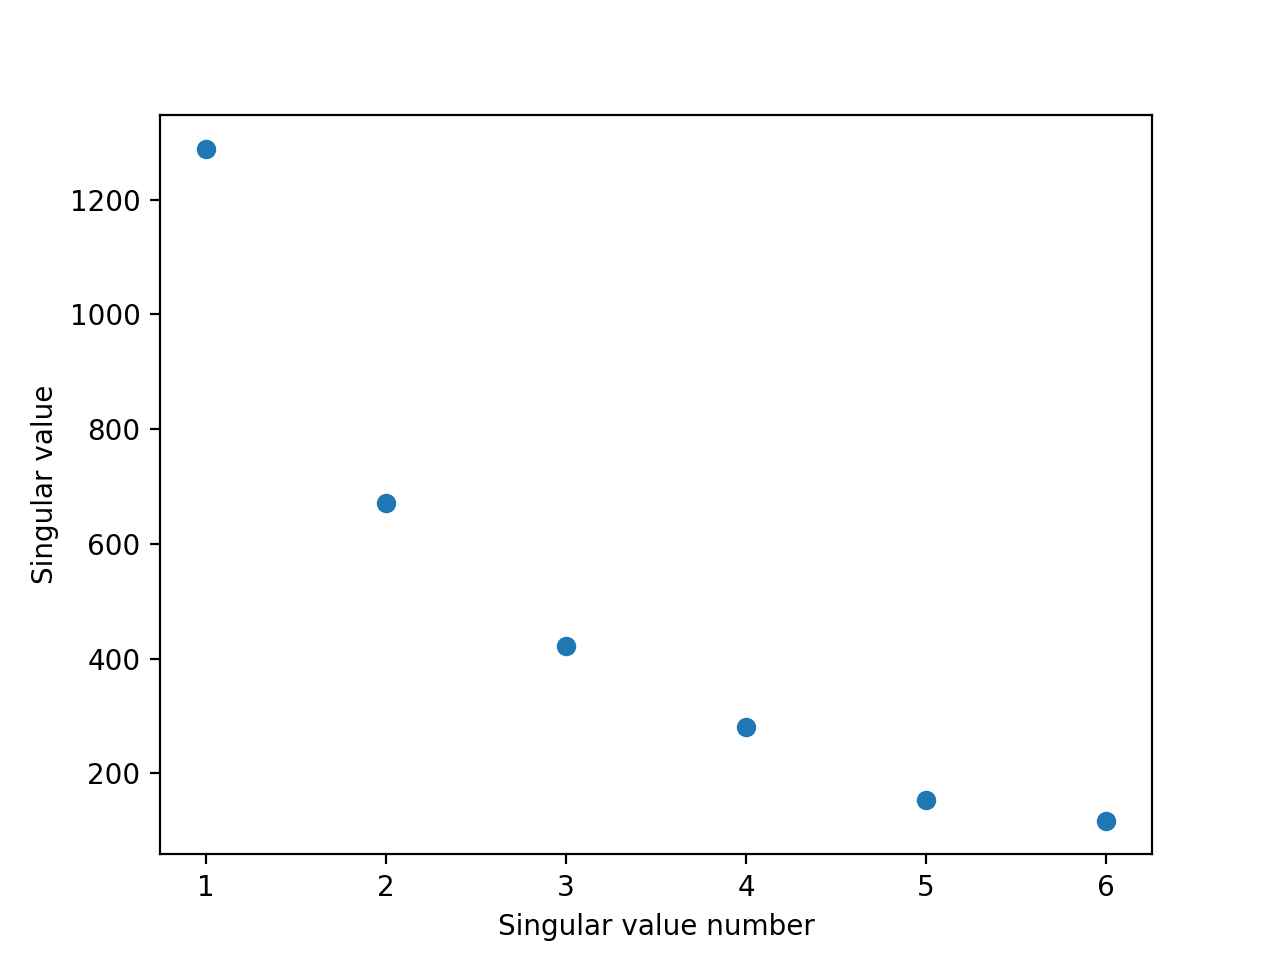

<IPython.core.display.Javascript object>


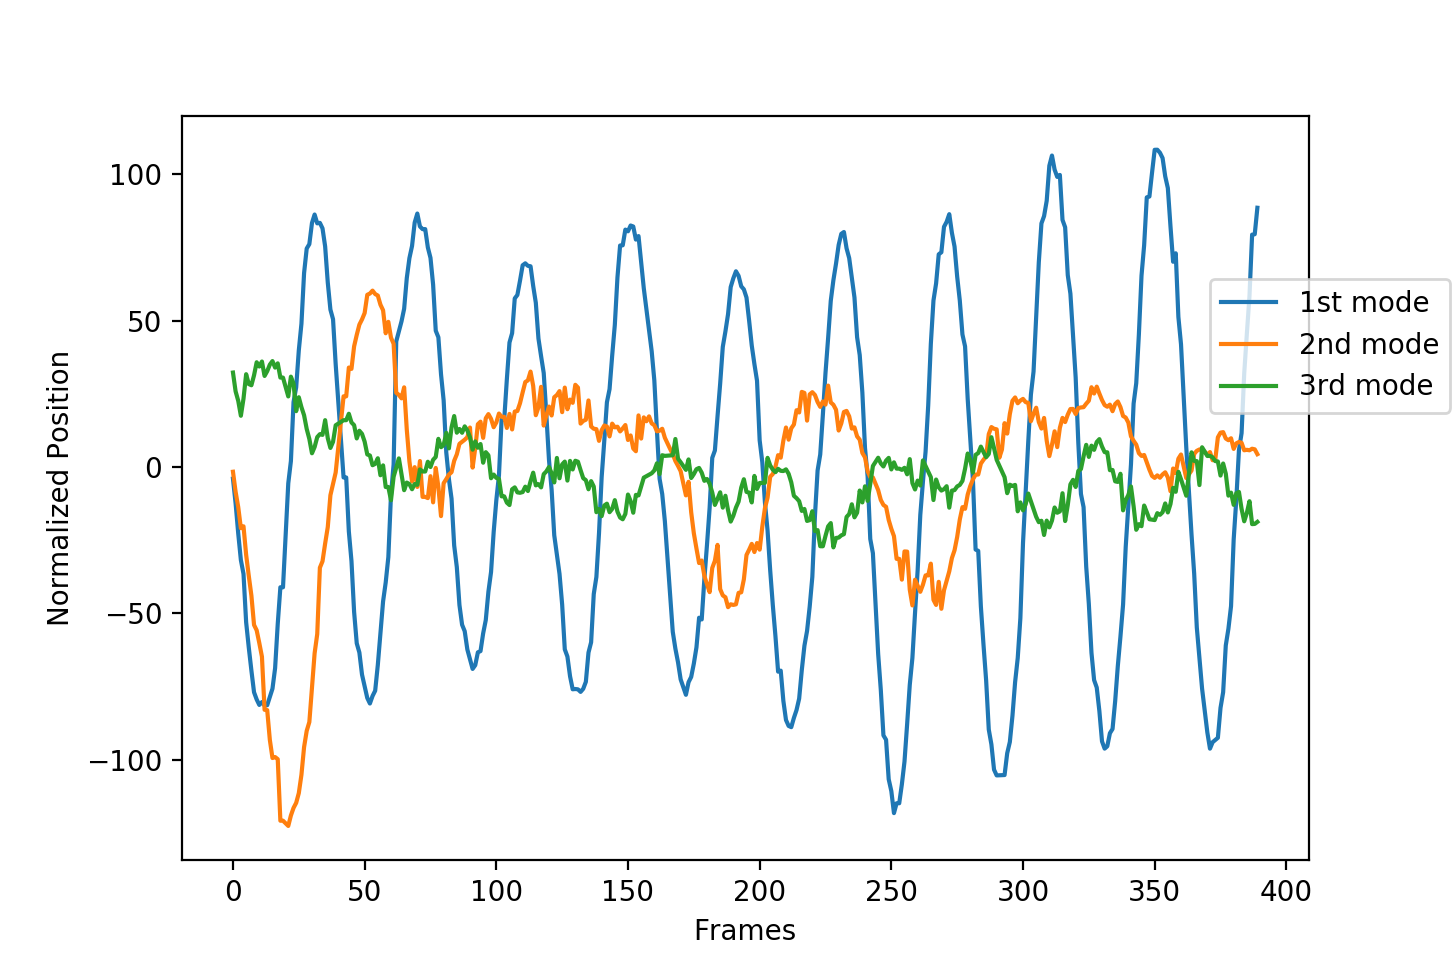

In [1991]:
# plot right singular vector (smoothened) (2 modes)
plt.figure(68)
plt.scatter(np.array([1,2,3,4,5,6]), s4)
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
plt.show()

plt.figure(69)
plt.plot(v4n[0]*s4[0], label = '1st mode')
plt.plot(v4n[1]*s4[1], label = '2nd mode')
plt.plot(v4n[2]*s4[2], label = '3rd mode')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.xlabel('Frames')
plt.ylabel('Normalized Position')

plt.show()

## Supplement: determine the color of the flashlight handle (used and saved in flashlight1,2,3 during repairing)

### Color of flashlight, Cam 3, Test 4

<IPython.core.display.Javascript object>


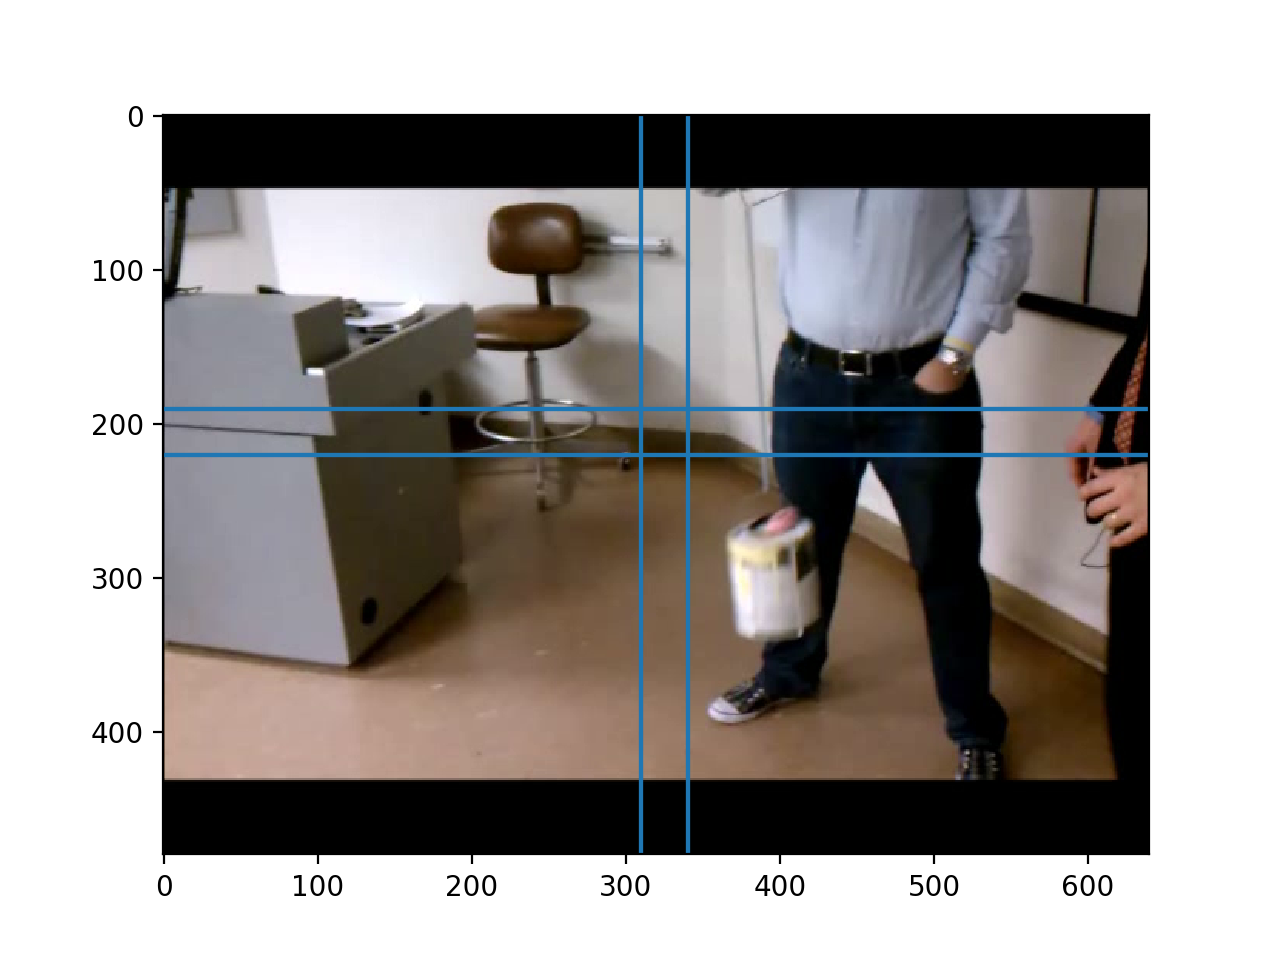

In [1625]:
plt.figure(104)
fnum = 15
plt.imshow(cam34cn[:,:,:,fnum])
plt.axvline(310)
plt.axvline(340)
plt.axhline(220)
plt.axhline(190)
plt.show()

In [1630]:
flashcolor0 = cam34cn[231:240,360:367,:,0].reshape((63,3))
flashcolor5 = cam34cn[229:236,338:344,:,5].reshape((42,3))
flashcolor10 = cam34cn[217:221,319:324,:,10].reshape((20,3))
flashcolor15 = cam34cn[203:212,320:326,:,15].reshape((54,3))

In [1629]:
plt.figure(105)
fnum = 15
plt.imshow(cam34cn[190:220,310:340,:,fnum])
plt.axvline(10)
plt.axvline(15)
plt.axhline(13)
plt.axhline(21)
plt.show()

<IPython.core.display.Javascript object>

In [1659]:
flashcolor = np.concatenate((flashcolor0, flashcolor5, flashcolor10, flashcolor15)).copy()
#flashcolor = np.unique(flashcolor, axis = 0)

In [1660]:
flashcolor.mean(axis = 0)

array([160.52513966, 125.34636872, 116.02234637])

<IPython.core.display.Javascript object>


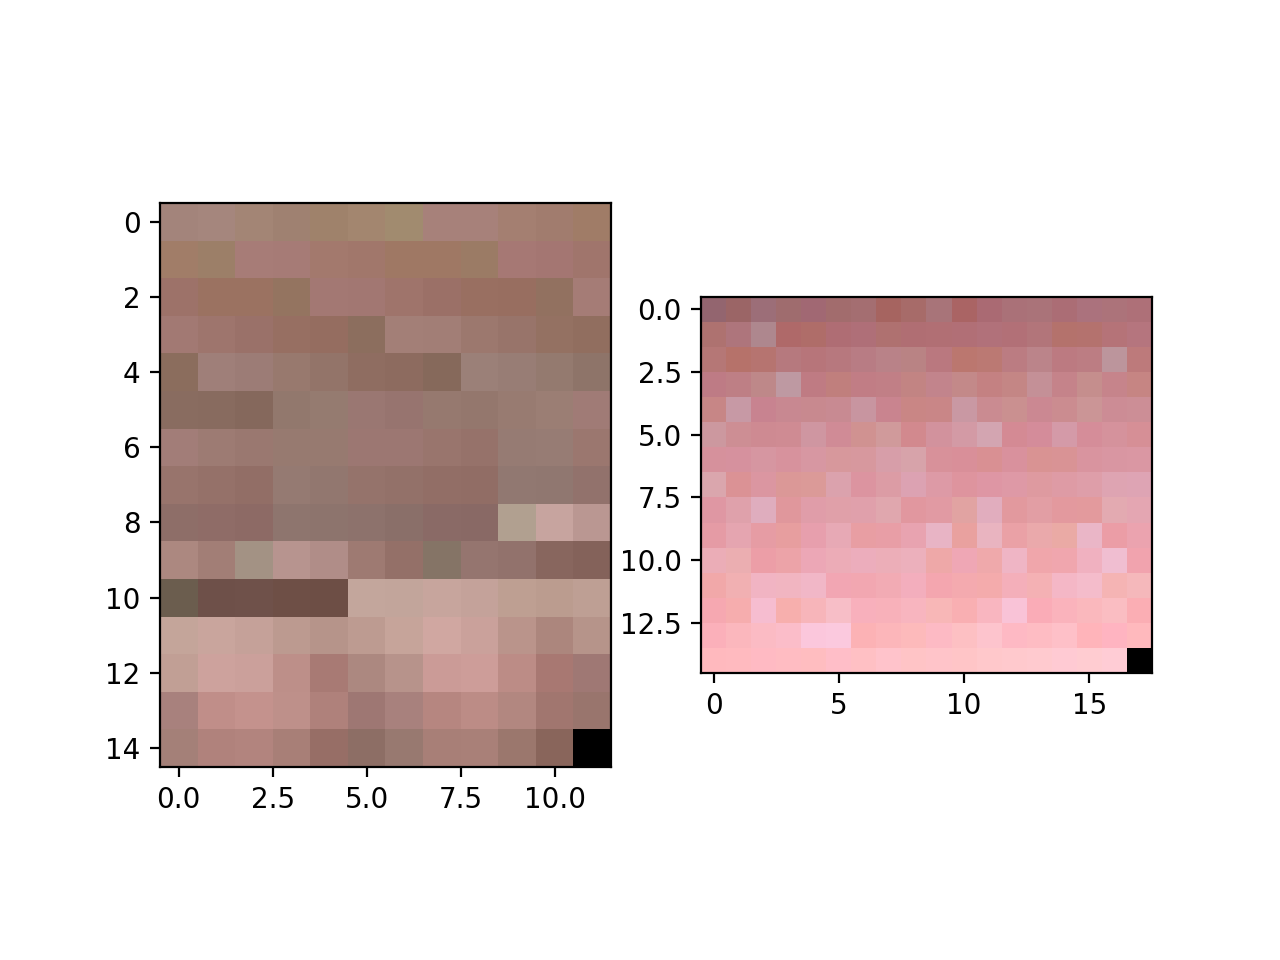

In [1675]:
plt.figure(108)
plt.subplot(1,2,1)
test = np.concatenate((flashcolor, np.array([[0,0,0]]))).reshape((15,12,3))
plt.imshow(test)
plt.subplot(1,2,2)
plt.imshow(np.unique(flashcolor, axis = 0).reshape((15,11,3)))
plt.show()

In [1969]:
flashcoloru = np.unique(flashcolor, axis = 0).reshape((15,11,3))
flashcoloru[12:15].reshape(33, 3).mean(axis = 0)

array([193.12121212, 154.75757576, 147.09090909])

In [1970]:
# flashlight3
plt.figure(109)
plt.imshow(np.array([[[193, 155, 147]]]))
plt.show()

<IPython.core.display.Javascript object>

### Color of flashlight, Cam 1, Test 4

<IPython.core.display.Javascript object>


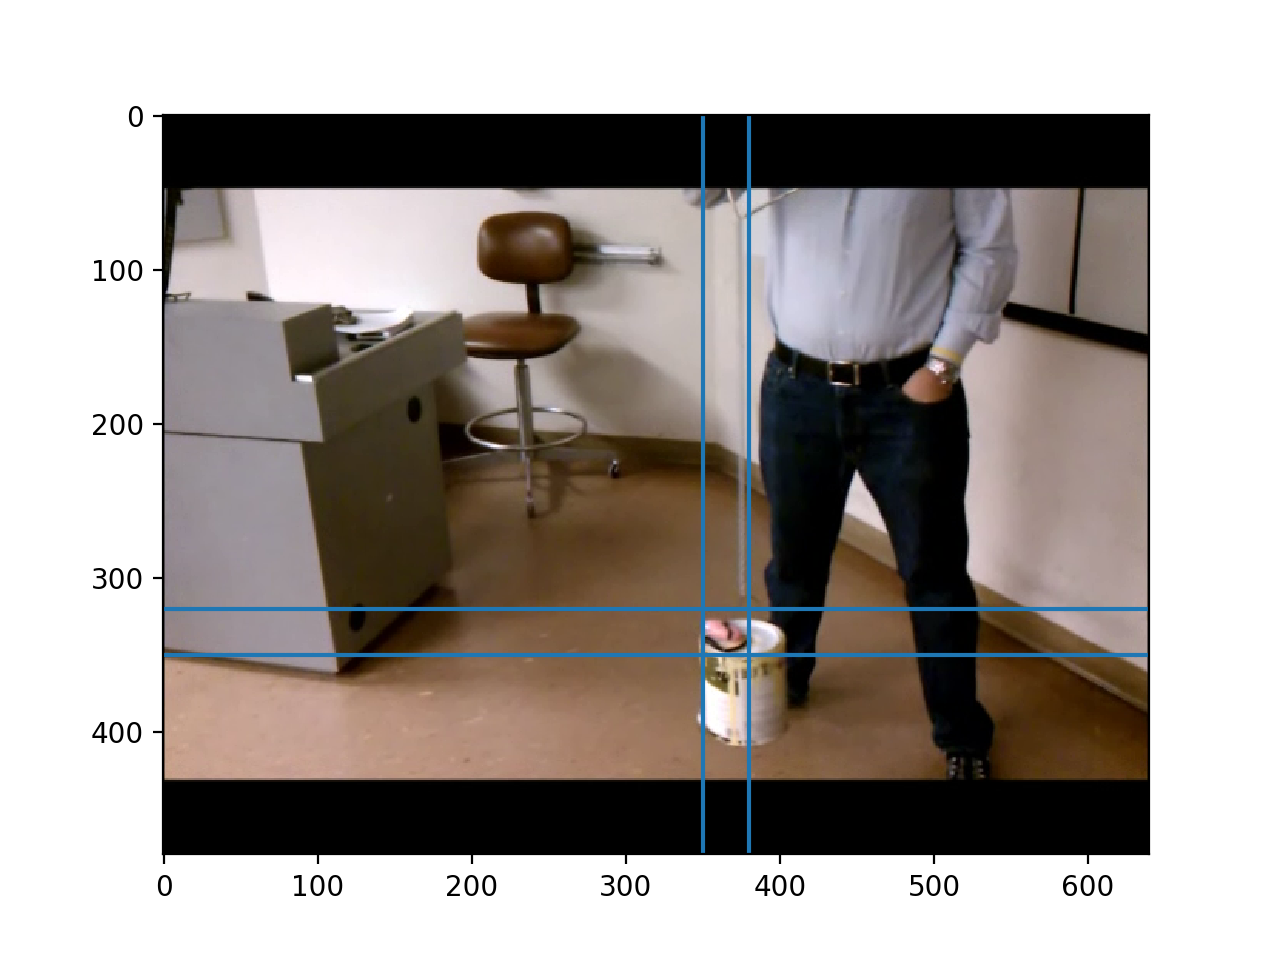

In [1832]:
plt.figure(114)
fnum = 70
plt.imshow(cam14cn[:,:,:,fnum])
plt.axvline(380)
plt.axvline(350)
plt.axhline(350)
plt.axhline(320)
plt.show()

In [1797]:
flashcolor0 = cam14cn[263:271,394:401,:,0].reshape((56,3))
flashcolor00 = cam14cn[260:269,401:406,:,0].reshape((45,3))
flashcolor10 = cam14cn[251:258,413:423,:,10].reshape((70,3))
flashcolor1010 = cam14cn[250:254,423:430,:,10].reshape((28,3))
flashcolor70 = cam14cn[330:338,355:362,:,70].reshape((56,3))
flashcolor7070 = cam14cn[334:340,362:366,:,70].reshape((24,3))

In [1796]:
plt.figure(115)
fnum = 70
plt.imshow(cam14cn[320:350,350:380,:,fnum])
plt.axvline(15)
plt.axvline(12)
plt.axhline(14) # add to first index
plt.axhline(19)
plt.show()

<IPython.core.display.Javascript object>

In [1799]:
flashcolor1 = np.concatenate((flashcolor0, flashcolor00, flashcolor10, flashcolor1010, flashcolor70, flashcolor7070)).copy()

In [1825]:
flashcolor11 = np.concatenate((flashcolor00, flashcolor1010, flashcolor70)).copy()

In [1800]:
flashcolor1.mean(axis = 0)

array([217.03225806, 152.99641577, 160.08960573])

In [1826]:
# flashlight1 (finally used)
flashcolor11.mean(axis = 0)

array([209.40310078, 146.03100775, 151.91472868])

<IPython.core.display.Javascript object>


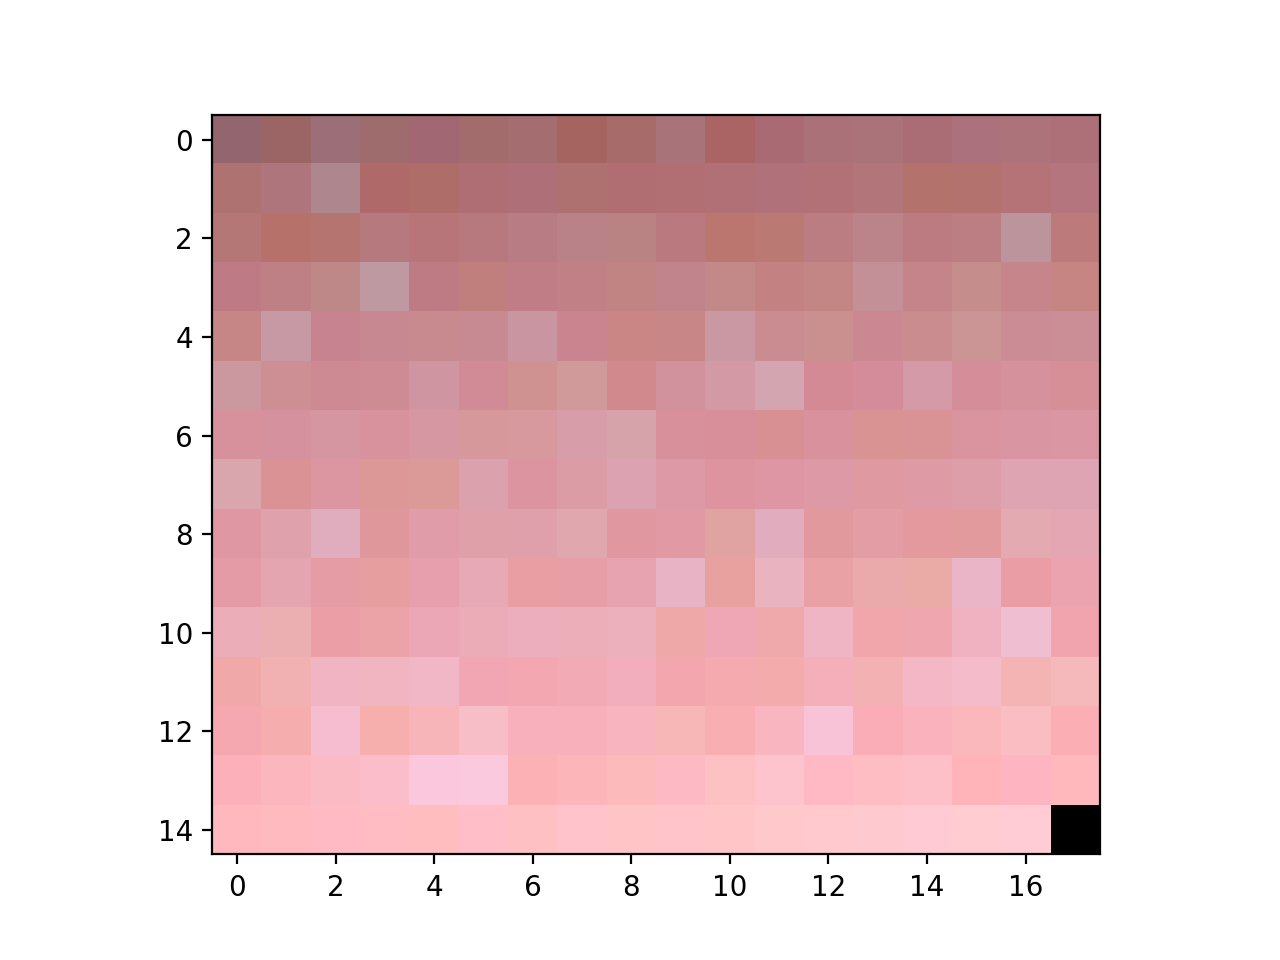

In [1808]:
test = np.concatenate((np.unique(flashcolor1, axis = 0), np.array([[0,0,0]])))
plt.figure(118)
plt.imshow(test.reshape((15,18,3)))
plt.show()

<IPython.core.display.Javascript object>


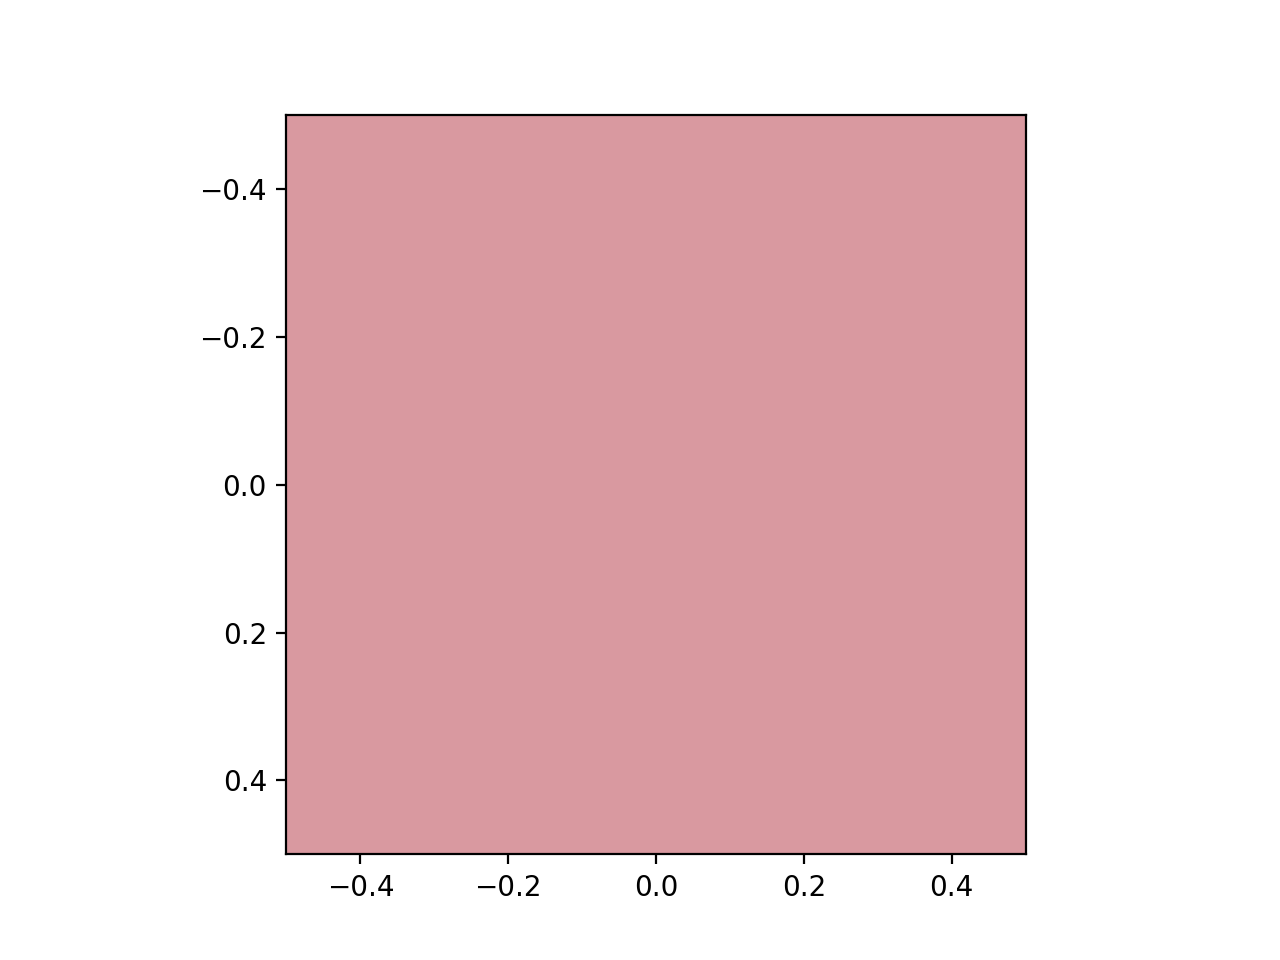

In [1814]:
# flashlight1
plt.figure(119)
plt.imshow(np.array([[[217, 153, 160]]]))
plt.show()

### Color of flashlight, Cam 2, Test 4

<IPython.core.display.Javascript object>


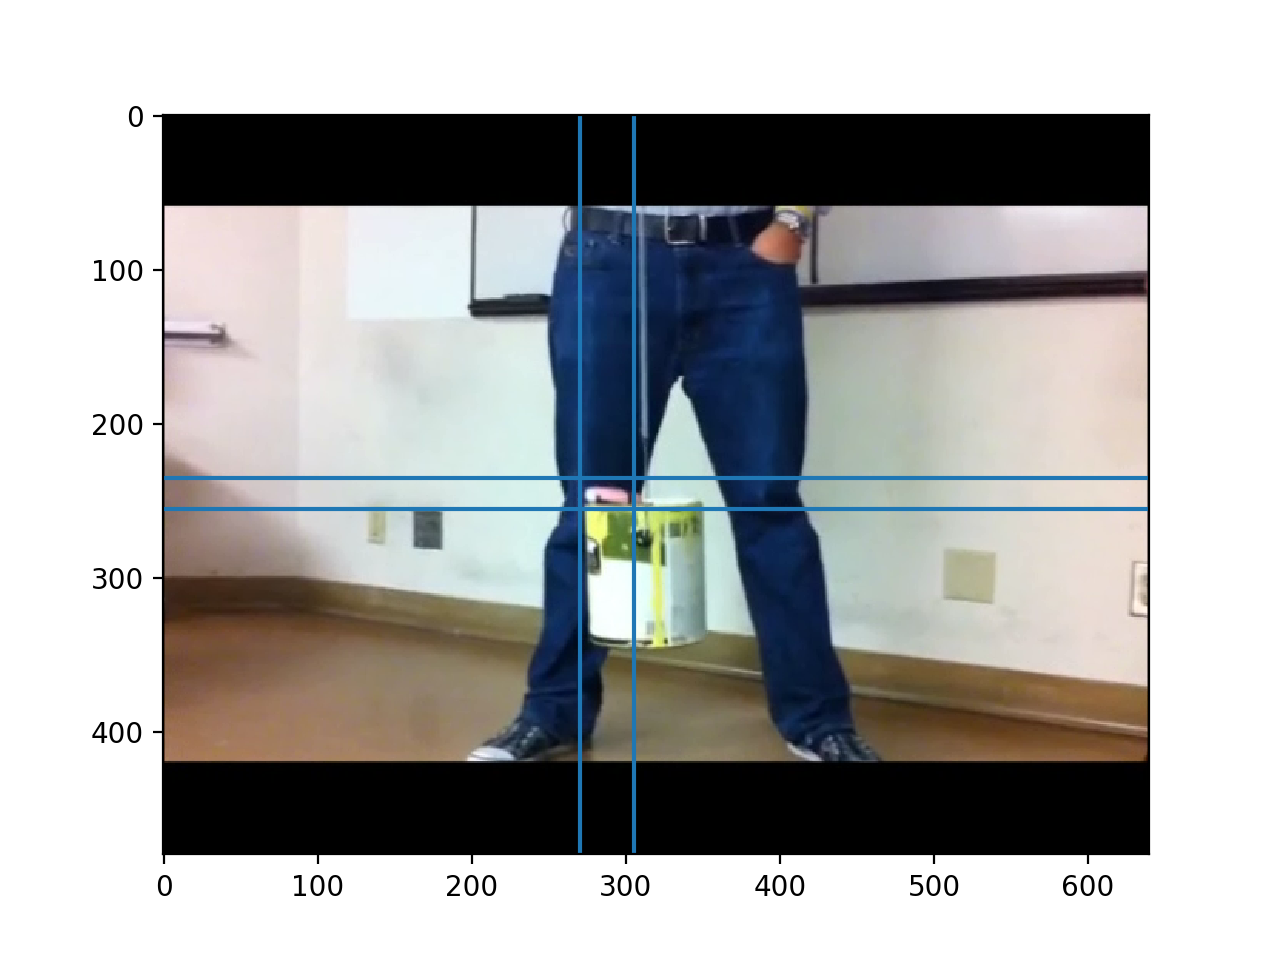

In [1864]:
plt.figure(154)
fnum = 70
plt.imshow(cam24cn[:,:,:,fnum])
plt.axvline(305)
plt.axvline(270)
plt.axhline(255)
plt.axhline(235)
plt.show()

In [1874]:
flashcolor0 = cam24cn[200:205,289:294,:,0].reshape((25,3))
flashcolor5 = cam24cn[160:165,324:330,:,5].reshape((30,3))
flashcolor70 = cam24cn[245:250,286:298,:,70].reshape((60,3))

<IPython.core.display.Javascript object>


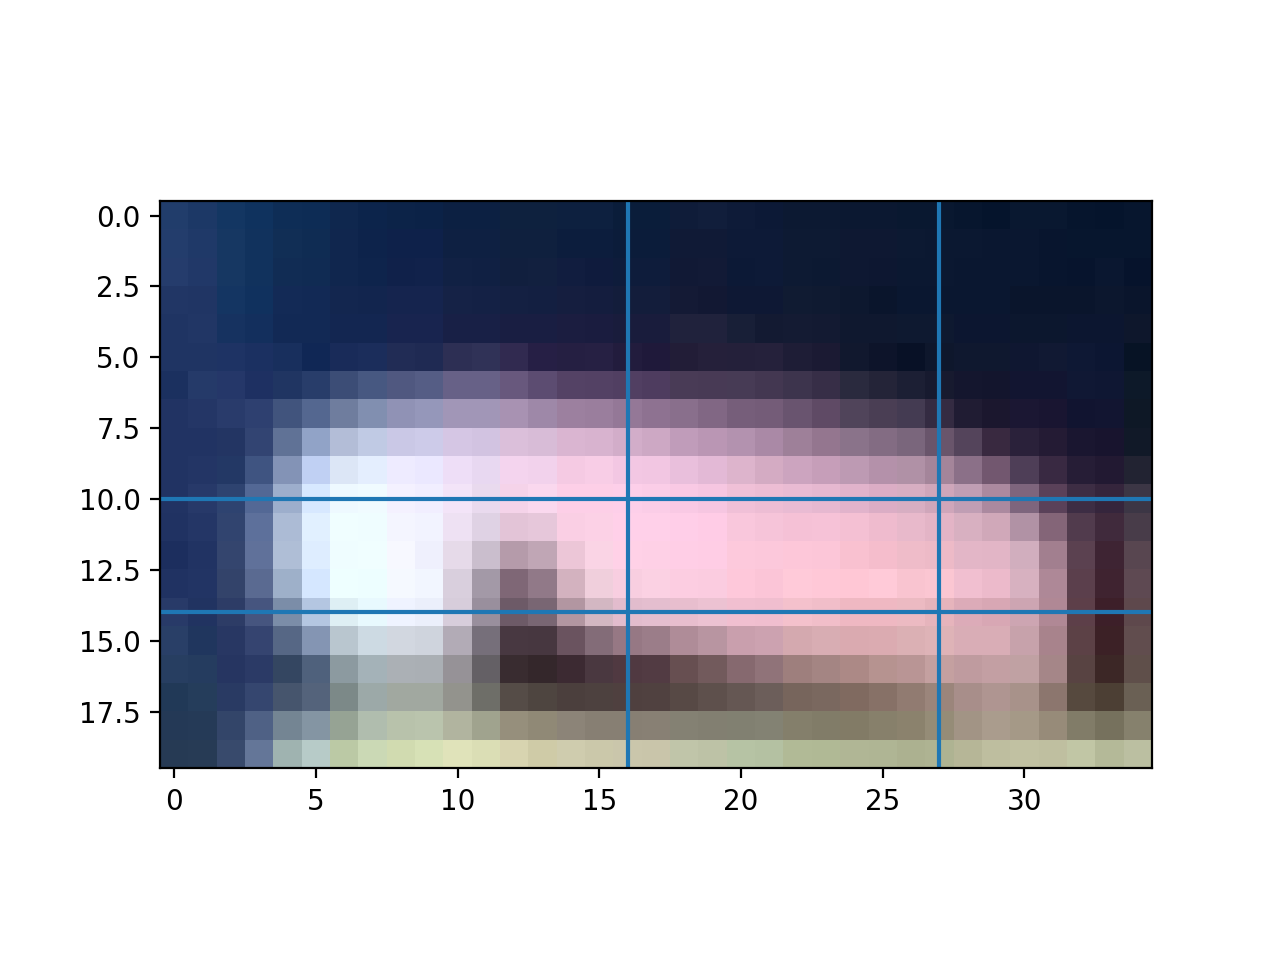

In [1873]:
plt.figure(155)
fnum = 70
plt.imshow(cam24cn[235:255,270:305,:,fnum])
plt.axvline(27)
plt.axvline(16)
plt.axhline(14) # add to first index
plt.axhline(10)
plt.show()

In [1876]:
flashcolor2 = np.concatenate((flashcolor0, flashcolor5, flashcolor70)).copy()
flashcolor2.mean(axis = 0)

array([220.11304348, 176.56521739, 188.09565217])

In [1882]:
test = np.unique(np.concatenate((flashcolor2, np.array([[0,0,0],[1,1,1]]) )), axis = 0)
plt.figure(158)
plt.imshow(test.reshape((23,5,3)))
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


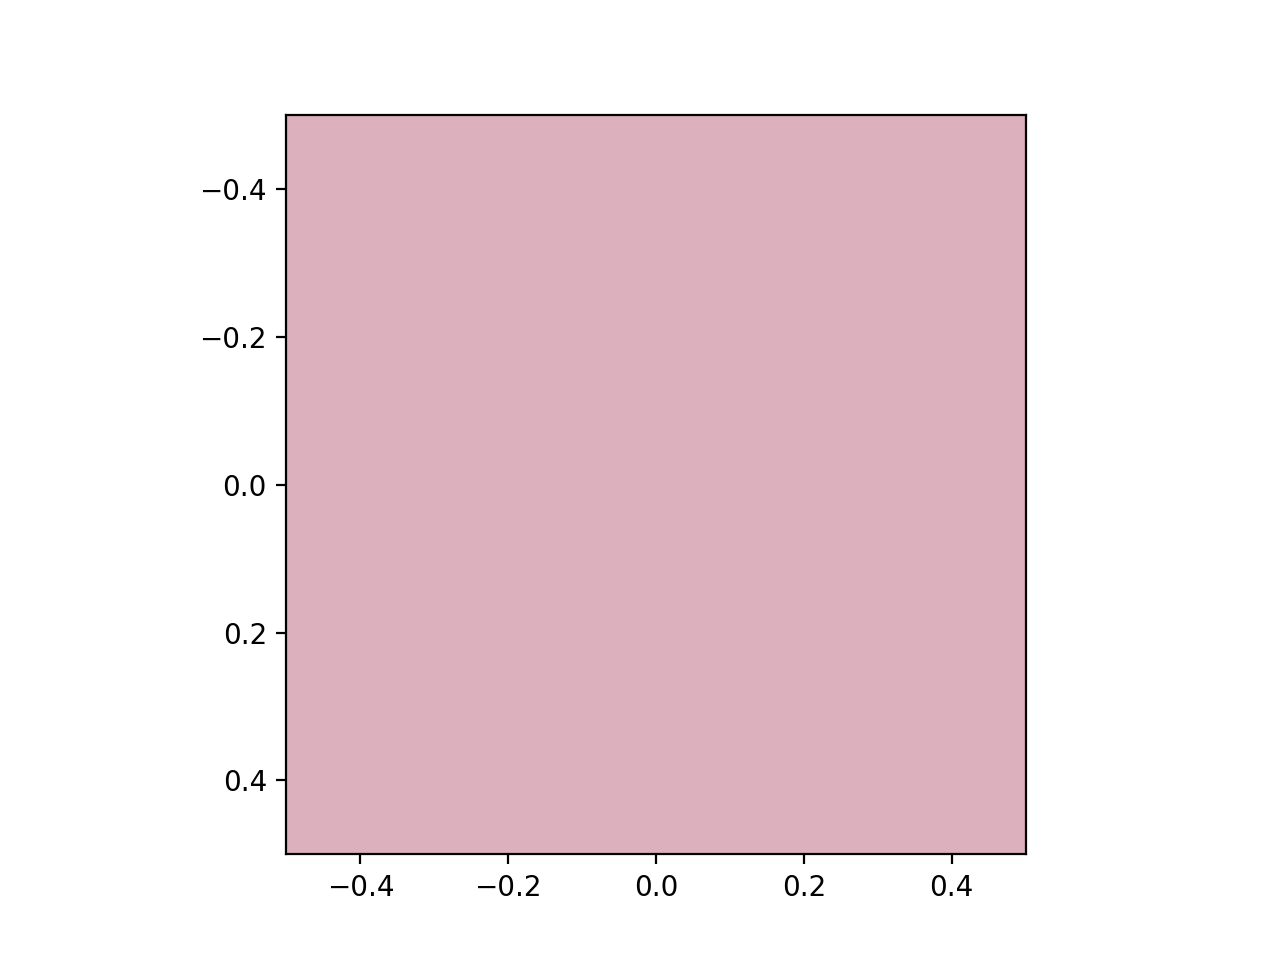

In [1883]:
# flashlight2
plt.figure(159)
plt.imshow(np.array([[[220, 176, 188]]]))
plt.show()